# FomulaBEAT

4-1-3からの変更点
- データを空白を削除したもの（03-3）
- 次元を16次元にする



In [1]:
version = '04-1-4'
model_dir = './model/' + version
data_path = 'data/eq03-3.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['++52+93', '++29+50', '++88+11'] ['52+93++', '29+50++', '88+11++']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13, '+': 14}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 14, 10, 14, 10, 1, 10, 5, 10, 14, 10, 8, 10, 5, 13]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12, 14, 14,  6,  8, 14,  6,  8, 13])
Output: tensor([12,  6,  8, 14,  6,  8, 14, 14, 13])
元に戻した文章
Input: ++68+68
Output: 68+68++


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

80000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 16
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 16, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([15, 16])
値: Parameter containing:
tensor([[-0.2848, -0.2603,  0.1038,  0.1419,  0.1599, -0.1783, -0.1759,  0.0542, -0.2403, -0.0336,
          0.0126,  0.0612,  0.2042, -0.3640,  0.4059,  0.1702],
        [-0.3552,  0.1329,  0.1722, -0.1501, -0.1302,  0.1660,  0.4024, -0.2261, -0.1640,  0.2498,
          0.1940, -0.3389, -0.2114, -0.4159,  0.3257, -0.0969],
        [ 0.3579,  0.0564, -0.1684,  0.3352,  0.1691, -0.0760,  0.3015,  0.1768, -0.0536, -0.2225,
         -0.3474,  0.4048,  0.2576,  0.1274,  0.3566, -0.0434],
        [ 0.2238,  0.0192,  0.3076, -0.3128,  0.0738,  0.3508,  0.0882,  0.3739, -0.2809,  0.4322,
         -0.4290,  0.1565,  0.3376,  0.1105,  0.2534,  0.1515],
        [ 0.4180,  0.1226, -0.2468, -0.2059,  0.0196, -0.0120, -0.2034,  0.3166,  0.0561,  0.0484,
         -0.0159, -0.3279, -0.1387, -0.1611, -0.0229, -0.2330],
        [ 0.1105,  0.0632,  0.1023,  0.0698, -0.1100,  0.1198, -0.0167, -0.3818,  0.3941,  0

## 学習実行

In [22]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/79 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 79/79 [00:01<00:00, 60.09it/s]


[1/100] train loss: 2.39, valid loss: 2.10  [1s] counter: 0 **


100%|██████████| 79/79 [00:01<00:00, 69.54it/s]


[2/100] train loss: 1.91, valid loss: 1.71  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.00it/s]


[3/100] train loss: 1.57, valid loss: 1.42  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.36it/s]


[4/100] train loss: 1.25, valid loss: 1.17  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[5/100] train loss: 1.12, valid loss: 1.08  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.79it/s]


[6/100] train loss: 1.04, valid loss: 0.98  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.06it/s]


[7/100] train loss: 0.88, valid loss: 0.76  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.49it/s]


[8/100] train loss: 0.62, valid loss: 0.54  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.92it/s]


[9/100] train loss: 0.50, valid loss: 0.47  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.80it/s]


[10/100] train loss: 0.45, valid loss: 0.44  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.22it/s]


[11/100] train loss: 0.43, valid loss: 0.42  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.22it/s]


[12/100] train loss: 0.41, valid loss: 0.41  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.92it/s]


[13/100] train loss: 0.40, valid loss: 0.40  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[14/100] train loss: 0.38, valid loss: 0.36  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.52it/s]


[15/100] train loss: 0.32, valid loss: 0.29  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.63it/s]


[16/100] train loss: 0.25, valid loss: 0.19  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.62it/s]


[17/100] train loss: 0.12, valid loss: 0.06  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.70it/s]


[18/100] train loss: 0.03, valid loss: 0.02  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.03it/s]


[19/100] train loss: 0.01, valid loss: 0.01  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.62it/s]


[20/100] train loss: 0.01, valid loss: 0.01  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[21/100] train loss: 0.01, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[22/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.46it/s]


[23/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.53it/s]


[24/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.58it/s]


[25/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.03it/s]


[26/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.71it/s]


[27/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.67it/s]


[28/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.41it/s]


[29/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[30/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.63it/s]


[31/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.45it/s]


[32/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.75it/s]


[33/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.07it/s]


[34/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.07it/s]


[35/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.31it/s]


[36/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.77it/s]


[37/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.06it/s]


[38/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.71it/s]


[39/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.54it/s]


[40/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.77it/s]


[41/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.02it/s]


[42/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.65it/s]


[43/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.71it/s]


[44/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.57it/s]


[45/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.13it/s]


[46/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.37it/s]


[47/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.26it/s]


[48/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.36it/s]


[49/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.65it/s]


[50/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.64it/s]


[51/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.69it/s]


[52/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.87it/s]


[53/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.79it/s]


[54/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.59it/s]


[55/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.87it/s]


[56/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 71.08it/s]


[57/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.53it/s]


[58/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.75it/s]


[59/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.22it/s]


[60/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.62it/s]


[61/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.69it/s]


[62/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.55it/s]


[63/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.09it/s]


[64/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.93it/s]


[65/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.67it/s]


[66/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.51it/s]


[67/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.84it/s]


[68/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.49it/s]


[69/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.88it/s]


[70/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.46it/s]


[71/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.94it/s]


[72/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.71it/s]


[73/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.99it/s]


[74/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.23it/s]


[75/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.26it/s]


[76/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.05it/s]


[77/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.84it/s]


[78/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.67it/s]


[79/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.60it/s]


[80/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.49it/s]


[81/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.18it/s]


[82/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.45it/s]


[83/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.77it/s]


[84/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.45it/s]


[85/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.32it/s]


[86/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.47it/s]


[87/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.20it/s]


[88/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.08it/s]


[89/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 67.89it/s]


[90/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.17it/s]


[91/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.09it/s]


[92/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 70.07it/s]


[93/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.56it/s]


[94/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.41it/s]


[95/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.13it/s]


[96/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.59it/s]


[97/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 69.62it/s]


[98/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.33it/s]


[99/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 68.78it/s]


[100/100] train loss: 0.00, valid loss: 0.00  [1s] counter: 1 **


学習したモデルの保存

In [23]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [24]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.compute_output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [56]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: ++15+85
Output: 15+85++


In [55]:
# 様々な入力を試してみる

text_list = {
'++15+85':'15+85++',
'++16+86':'16+86++',
'++95+71':'95+71++',
'++65+79':'65+79++',
'++92+60':'92+60++'}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input: {text}")
    print(f"Output: {translation}")
    print(f"Target: {tgt}")
    print('---')


Input: ++15+85
Output: 15+85++
Target: 15+85++
---
Input: ++16+86
Output: 16+86++
Target: 16+86++
---
Input: ++95+71
Output: 95+71++
Target: 95+71++
---
Input: ++65+79
Output: 65+79++
Target: 65+79++
---
Input: ++92+60
Output: 92+60++
Target: 92+60++
---


## モデルの動作を分析

In [57]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 16, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [58]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([15, 16])
decoder_layer.self_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.self_attn.in_proj_bias torch.Size([48])
decoder_layer.self_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.self_attn.out_proj.bias torch.Size([16])
decoder_layer.multihead_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.multihead_attn.in_proj_bias torch.Size([48])
decoder_layer.multihead_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.multihead_attn.out_proj.bias torch.Size([16])
decoder_layer.norm1.weight torch.Size([16])
decoder_layer.norm1.bias torch.Size([16])
decoder_layer.norm2.weight torch.Size([16])
decoder_layer.norm2.bias torch.Size([16])


In [59]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data


# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [60]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Embeddingを見る

tensor([[-0.0858, -0.2349],
        [-0.1135,  0.1410],
        [ 0.3057, -0.1128],
        [ 0.1792, -0.1608],
        [ 0.2908,  0.0738],
        [ 0.1181, -0.0150],
        [ 0.0941,  0.2265],
        [-0.1521, -0.1248],
        [-0.2821, -0.0702],
        [-0.0449, -0.0122],
        [ 0.1929, -0.5026],
        [ 0.4938, -0.0872],
        [-0.0155,  0.0869],
        [-0.4712,  0.0366],
        [-0.1505,  0.4533]])


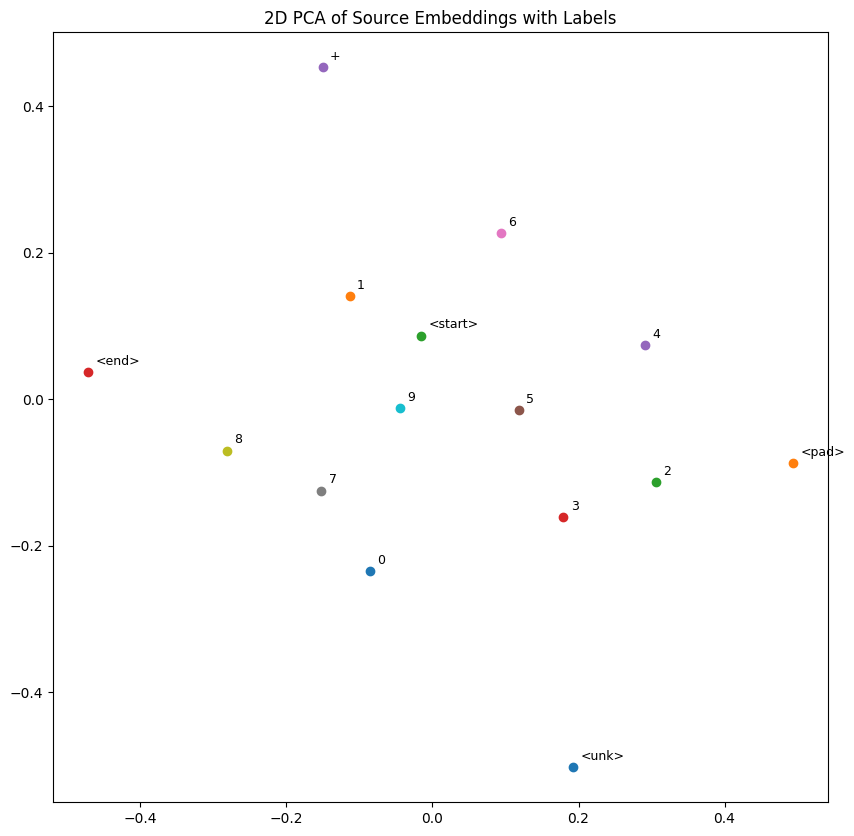

In [62]:
embedding_cpu = embedding_weight.cpu().detach()
print(embedding_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

## Attentionを確認

In [63]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: ++15+85
memory: tensor([[[-6.2177e-02,  1.3477e+00,  8.7057e-01,  2.9122e+00, -2.6757e+00,  6.4495e-01,  2.0359e+00,
           2.6638e+00,  5.6236e-01,  1.0902e+00, -1.0209e+00,  3.0590e+00, -2.7238e-01, -4.3942e-01,
           2.0376e+00,  2.3900e+00]],

        [[ 2.3946e-01,  2.3537e+00, -1.3705e+00, -7.5313e-01,  1.1791e+00,  2.3617e+00, -4.0416e-01,
          -1.9595e+00,  3.9489e+00,  2.7197e+00,  3.4515e+00,  3.2521e-01, -1.9478e+00,  3.5909e+00,
          -1.9810e+00,  1.0457e+00]],

        [[ 3.0729e-01,  1.3972e+00, -1.0903e+00, -8.9697e-01,  1.2780e+00,  2.3468e+00, -3.7257e-01,
          -1.9610e+00,  3.9589e+00,  2.7196e+00,  3.4547e+00,  3.2519e-01, -1.9468e+00,  3.5909e+00,
          -1.9807e+00,  1.0457e+00]],

        [[-3.1290e-01, -4.2584e-01,  6.1202e-01, -1.4813e-01,  5.5678e-01,  3.6560e+00,  3.1823e+00,
           1.7147e+00, -7.8036e-01,  4.6078e-01,  1.0276e+00, -4.1754e-01, -2.5029e+00, -2.1675e+00,
           1.7756e+00, -7.1500e-01]],

        [[-2.8

text: ++15+85
memory: tensor([[[-6.2177e-02,  1.3477e+00,  8.7057e-01,  2.9122e+00, -2.6757e+00,  6.4495e-01,  2.0359e+00,
           2.6638e+00,  5.6236e-01,  1.0902e+00, -1.0209e+00,  3.0590e+00, -2.7238e-01, -4.3942e-01,
           2.0376e+00,  2.3900e+00]],

        [[ 2.3946e-01,  2.3537e+00, -1.3705e+00, -7.5313e-01,  1.1791e+00,  2.3617e+00, -4.0416e-01,
          -1.9595e+00,  3.9489e+00,  2.7197e+00,  3.4515e+00,  3.2521e-01, -1.9478e+00,  3.5909e+00,
          -1.9810e+00,  1.0457e+00]],

        [[ 3.0729e-01,  1.3972e+00, -1.0903e+00, -8.9697e-01,  1.2780e+00,  2.3468e+00, -3.7257e-01,
          -1.9610e+00,  3.9589e+00,  2.7196e+00,  3.4547e+00,  3.2519e-01, -1.9468e+00,  3.5909e+00,
          -1.9807e+00,  1.0457e+00]],

        [[-3.1290e-01, -4.2584e-01,  6.1202e-01, -1.4813e-01,  5.5678e-01,  3.6560e+00,  3.1823e+00,
           1.7147e+00, -7.8036e-01,  4.6078e-01,  1.0276e+00, -4.1754e-01, -2.5029e+00, -2.1675e+00,
           1.7756e+00, -7.1500e-01]],

        [[-2.8

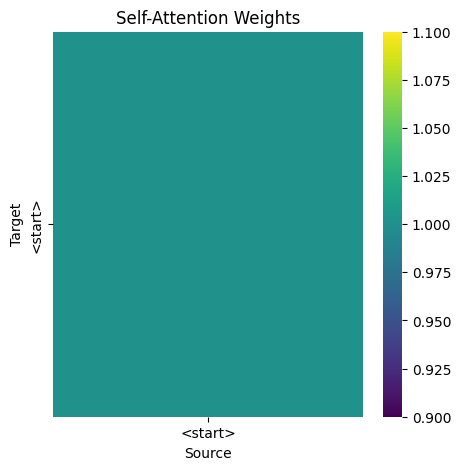

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
multi_attention: 
[[2.9831168e-10 3.6119067e-04 6.8948328e-02 8.4344918e-01 8.7047331e-02
  1.9134821e-04 6.5396409e-07 1.1431820e-06 8.7301760e-07]]
After Attention: tensor([[[ 0.4959,  0.7089, -0.7574, -0.9721,  0.2753,  3.9343,  5.4522,  1.1270, -1.5994, -0.9923,
           2.6609, -2.1797, -2.7512, -3.2829,  1.1380, -0.7435]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


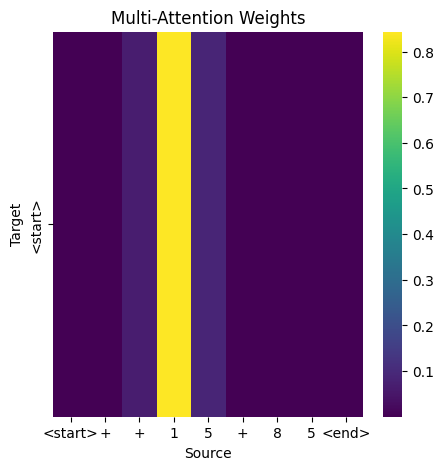

output.shape: torch.Size([1, 15])
output: tensor([[-0.4644, 14.3990, -2.9868,  0.4749,  2.3839, -7.7942,  2.2271,  0.9008,  2.9862,  0.0561,
         -1.2090,  0.0552,  1.7765, -9.5544,  0.2717]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[12],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -

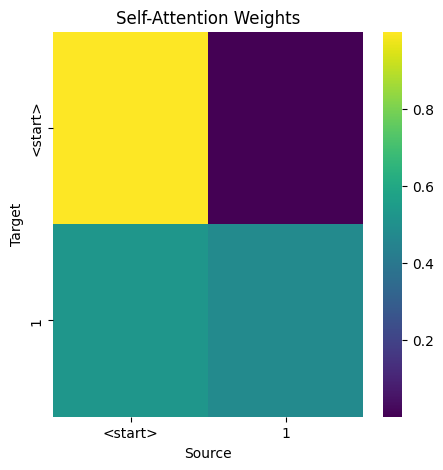

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
multi_attention: 
[[2.9839817e-10 3.6117656e-04 6.8946876e-02 8.4344596e-01 8.7052062e-02
  1.9134785e-04 6.5394789e-07 1.1430828e-06 8.7334899e-07]
 [3.0025584e-04 1.7465856e-05 6.4720160e-05 4.3703220e-03 9.8631996e-01
  3.7891013e-03 3.0020389e-03 4.5887125e-04 1.6771627e-03]]
After Attention: tensor([[[ 0.4959,  0.7089, -0.7574, -0.9720,  0.2753,  3.9343,  5.4522,  1.1270, -1.5994, -0.9923,
           2.6609, -2.1797, -2.7512, -3.2829,  1.1380, -0.7435]],

        [[ 1.1094,  0.4649,  0.9029, -0.1400,  0.3249,  1.1820, -3.0876, -3.1062,  3.8489,  0.5910,
          -5.5636,  1.5509, -0.1130,  2.7631, -1.2479, -1.5432]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


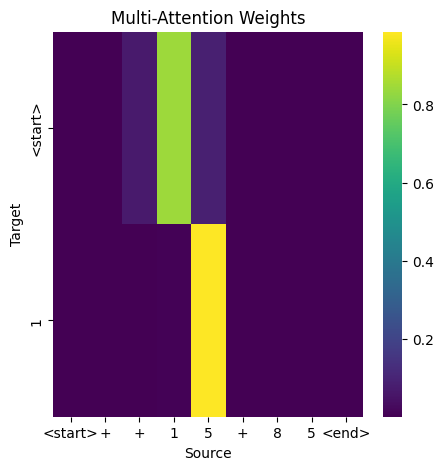

output.shape: torch.Size([1, 15])
output: tensor([[-5.7221, -7.0368,  0.7268,  1.6408,  2.8152, 14.9078,  1.1470,  3.6161,  3.4917,  1.3660,
         -0.6962, -1.1041, -2.4189, -1.5423,  4.2811]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[12],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]],

        [[ 1.3818, -0.4761,  0.8887,  0.5591, -0.0390,  2.0358, -1.2636, -0.4824,  2.9522,  1.5847,
          -4.7322,  3.0282, -0.2713,  2.5310, -0.9840, -0.5136]]], device='cuda:0')
now tgt: 15
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
     

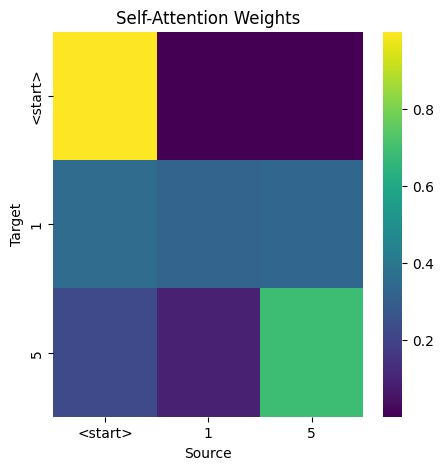

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
multi_attention: 
[[2.9843228e-10 3.6120578e-04 6.8952262e-02 8.4344256e-01 8.7050050e-02
  1.9134178e-04 6.5395642e-07 1.1431545e-06 8.7341130e-07]
 [7.8222975e-02 8.6782854e-03 1.9945601e-02 1.8704746e-02 6.8297470e-01
  5.7272720e-03 3.9150409e-02 1.1734285e-01 2.9253256e-02]
 [9.9520737e-01 1.8628450e-06 2.9504579e-07 1.7005939e-06 1.1434201e-06
  1.6605757e-06 3.5882462e-04 4.2691507e-05 4.3843323e-03]]
After Attention: tensor([[[ 0.4959,  0.7089, -0.7575, -0.9720,  0.2753,  3.9343,  5.4522,  1.1270, -1.5995, -0.9923,
           2.6609, -2.1797, -2.7512, -3.2829,  1.1380, -0.7434]],

        [[ 0.4290,  0.5497,  0.7023,  0.0942,  0.4885,  0.8570, -2.7663, -3.1593,  3.8580,  0.8265,
          -5.8623,  1.6388, -0.2959,  2.7627, -1.1545, -1.2904]],

        [[-0.7761,  1.6396, -1.2888, -0.7787,  0.9011,  1.4558, 

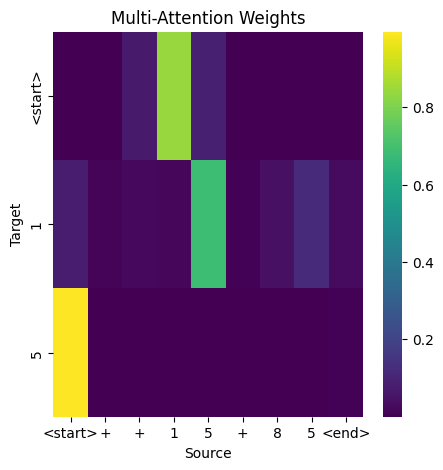

output.shape: torch.Size([1, 15])
output: tensor([[-8.4967,  0.7375, -6.6014, -6.1832, -0.7549,  2.8834,  1.8775,  2.1665,  0.7863, -2.5841,
          1.1800, -0.6702, -5.5752,  2.1486, 16.2580]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 3
ys: tensor([[12],
        [ 1],
        [ 5],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]],

        [[ 1.3818, -0.4761,  0.8887,  0.5591, -0.0390,  2.0358, -1.2636, -0.4824,  2.9522,  1.5847,
          -4.7322,  3.0282, -0.2713,  2.5310, -0.9840, -0.5136]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
           3.4579,  0.3252, -1

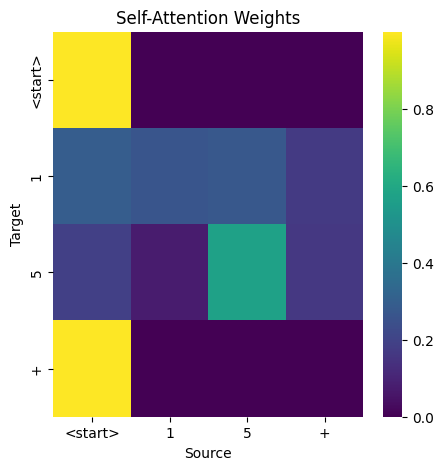

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
multi_attention: 
[[2.9843228e-10 3.6120578e-04 6.8952262e-02 8.4344256e-01 8.7050050e-02
  1.9134178e-04 6.5395642e-07 1.1431545e-06 8.7341130e-07]
 [5.2395076e-01 2.6148774e-03 4.9533853e-03 4.3749841e-04 1.0942880e-02
  2.3718081e-04 1.0491828e-03 5.7587107e-03 4.5005557e-01]
 [9.7512895e-01 1.3833855e-07 2.0278357e-08 1.7789883e-08 1.1194372e-08
  4.5152404e-08 2.9137798e-06 4.4075861e-07 2.4867421e-02]
 [3.5681825e-02 2.5708692e-05 2.8166664e-06 2.4482500e-04 5.0996412e-02
  8.3243564e-02 7.9489803e-01 2.5641276e-02 9.2655206e-03]]
After Attention: tensor([[[ 4.9587e-01,  7.0887e-01, -7.5746e-01, -9.7202e-01,  2.7529e-01,  3.9343e+00,  5.4522e+00,
           1.1270e+00, -1.5995e+00, -9.9229e-01,  2.6609e+00, -2.1797e+00, -2.7512e+00, -3.2829e+00,
           1.1380e+00, -7.4343e-01]],

        [[-2.1575e+00,  6.

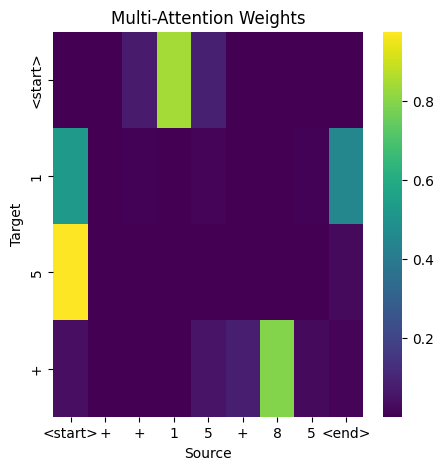

output.shape: torch.Size([1, 15])
output: tensor([[-4.4261,  2.1004,  0.5520,  0.5551, -9.8831,  3.3607,  0.5326,  0.5545, 14.2132,  2.4705,
         -2.0294,  0.4854,  0.7876, -4.0359,  1.7089]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 4
ys: tensor([[12],
        [ 1],
        [ 5],
        [14],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]],

        [[ 1.3818, -0.4761,  0.8887,  0.5591, -0.0390,  2.0358, -1.2636, -0.4824,  2.9522,  1.5847,
          -4.7322,  3.0282, -0.2713,  2.5310, -0.9840, -0.5136]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
           3.4579

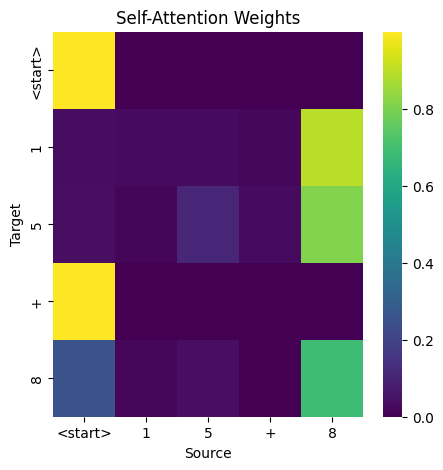

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
multi_attention: 
[[3.0162181e-10 3.6229362e-04 6.9158442e-02 8.4336799e-01 8.6917788e-02
  1.9081702e-04 6.5460313e-07 1.1451451e-06 8.7985393e-07]
 [3.5296211e-01 2.0365404e-02 4.3373600e-02 4.5136061e-02 2.9173848e-01
  4.8224879e-03 7.5502761e-02 1.2071546e-01 4.5383684e-02]
 [9.7802985e-01 7.4244588e-07 1.6569574e-07 1.3469581e-05 1.0673399e-05
  1.5917474e-05 1.0155014e-03 9.7957227e-06 2.0903891e-02]
 [3.5685495e-02 2.5707428e-05 2.8164361e-06 2.4480105e-04 5.0992459e-02
  8.3238788e-02 7.9490286e-01 2.5641149e-02 9.2658596e-03]
 [3.8112782e-02 1.5336702e-02 5.0184317e-03 2.1581659e-03 9.3078811e-04
  4.1166050e-04 1.1770064e-02 9.2511511e-01 1.1464031e-03]]
After Attention: tensor([[[ 0.4956,  0.7086, -0.7593, -0.9710,  0.2765,  3.9322,  5.4529,  1.1284, -1.6025, -0.9930,
           2.6607, -2.1793, -2.7501,

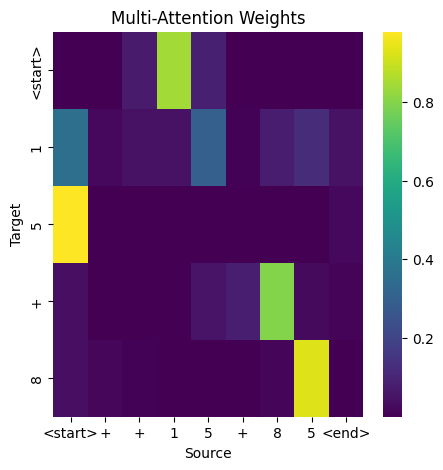

output.shape: torch.Size([1, 15])
output: tensor([[-4.6542, -7.2438,  2.7409,  2.9238,  2.5211, 15.0662,  1.8514,  2.0402,  4.3505,  2.2990,
         -1.2433, -1.9163, -1.0027, -1.8593,  1.7475]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[12],
        [ 1],
        [ 5],
        [14],
        [ 8],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]],

        [[ 1.3818, -0.4761,  0.8887,  0.5591, -0.0390,  2.0358, -1.2636, -0.4824,  2.9522,  1.5847,
          -4.7322,  3.0282, -0.2713,  2.5310, -0.9840, -0.5136]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
   

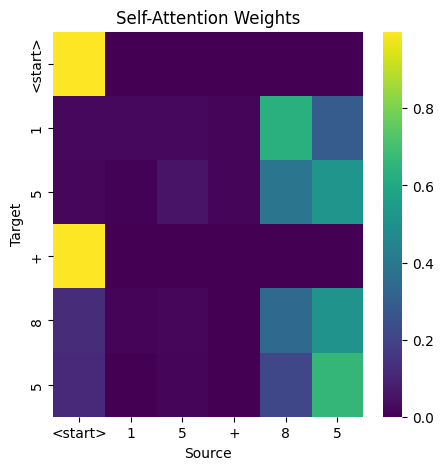

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
multi_attention: 
[[3.0212297e-10 3.6287311e-04 6.9270596e-02 8.4331077e-01 8.6862423e-02
  1.9068040e-04 6.5459051e-07 1.1463950e-06 8.8079747e-07]
 [3.1931260e-01 7.6146930e-02 1.3780127e-01 2.2200311e-02 7.5803153e-02
  2.3893784e-03 4.3980069e-02 2.8683621e-01 3.5530079e-02]
 [9.9092156e-01 1.1657076e-05 2.1604014e-06 3.3044389e-06 8.7259480e-07
  2.2947777e-06 3.8050459e-04 8.2218619e-05 8.5955625e-03]
 [3.6098789e-02 2.5692214e-05 2.8034885e-06 2.4189948e-04 5.0464492e-02
  8.2632937e-02 7.9549080e-01 2.5745643e-02 9.2969481e-03]
 [6.3917257e-02 6.2081788e-02 1.5158046e-02 6.1092076e-05 1.2023205e-05
  1.5723446e-05 1.0727339e-03 8.5666984e-01 1.0115155e-03]
 [9.9192977e-01 4.0207990e-04 5.0269173e-05 6.2332992e-06 6.4283347e-07
  3.8886647e-06 1.7473145e-03 4.0499512e-03 1.8098904e-03]]
After Attention: tenso

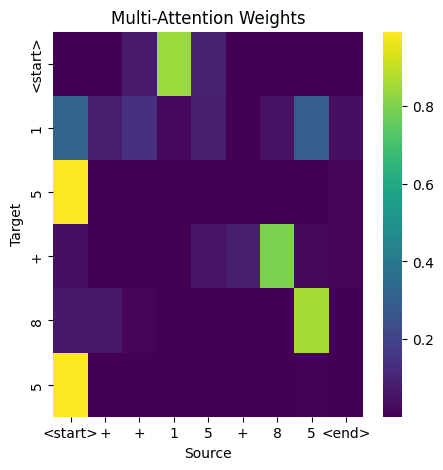

output.shape: torch.Size([1, 15])
output: tensor([[-8.3941,  0.7058, -6.5460, -6.2714, -1.1914,  2.3797,  1.8032,  1.8893,  0.7352, -2.8152,
          0.9756, -0.9090, -5.2199,  2.8518, 16.1814]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 6
ys: tensor([[12],
        [ 1],
        [ 5],
        [14],
        [ 8],
        [ 5],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]],

        [[ 1.3818, -0.4761,  0.8887,  0.5591, -0.0390,  2.0358, -1.2636, -0.4824,  2.9522,  1.5847,
          -4.7322,  3.0282, -0.2713,  2.5310, -0.9840, -0.5136]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.968

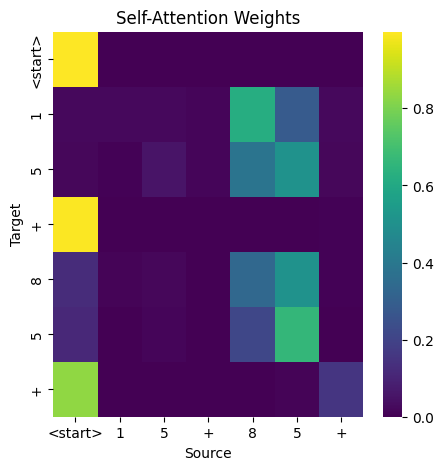

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
multi_attention: 
[[3.0212297e-10 3.6287311e-04 6.9270596e-02 8.4331077e-01 8.6862423e-02
  1.9068040e-04 6.5459051e-07 1.1463950e-06 8.8079747e-07]
 [4.3287686e-01 6.7235820e-02 1.1940119e-01 1.6327551e-02 5.7588063e-02
  1.9452856e-03 3.3514552e-02 2.1720764e-01 5.3903047e-02]
 [9.8958743e-01 7.5238077e-06 1.3672502e-06 1.8583237e-06 5.1166620e-07
  1.4787065e-06 2.1808044e-04 4.4913362e-05 1.0136843e-02]
 [4.2132694e-02 2.4438046e-05 2.5745110e-06 2.1702249e-04 4.7352668e-02
  8.0489904e-02 7.9400915e-01 2.5065398e-02 1.0706205e-02]
 [7.4349746e-02 6.3484214e-02 1.5325030e-02 5.8792633e-05 1.1620171e-05
  1.5629061e-05 1.0524264e-03 8.4449720e-01 1.2052947e-03]
 [9.9235618e-01 3.7835279e-04 4.7104080e-05 5.7613670e-06 5.9631452e-07
  3.6518595e-06 1.6273133e-03 3.7460020e-03 1.8350213e-03]
 [9.4535196e-01 3.82864

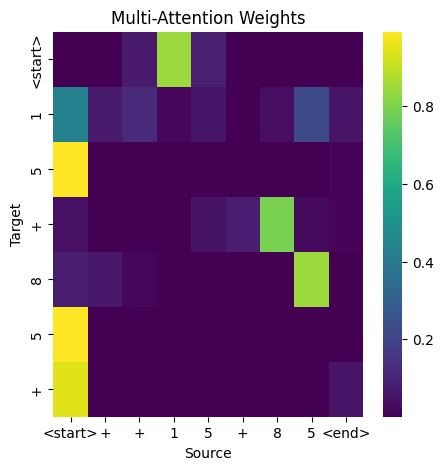

output.shape: torch.Size([1, 15])
output: tensor([[-8.6503e+00,  6.5679e-01, -6.0451e+00, -6.1987e+00, -2.1044e+00,  1.4566e+00,  6.2400e-01,
          2.0268e+00,  7.6024e-01, -3.1746e+00,  1.0319e+00,  1.0140e-02, -5.9324e+00,  2.7263e+00,
          1.6327e+01]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 7
ys: tensor([[12],
        [ 1],
        [ 5],
        [14],
        [ 8],
        [ 5],
        [14],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.3874,  1.1045,  0.1104,  0.2195,  0.3611,  3.6957,  3.1191,  1.7187, -0.8004,  0.4612,
           1.0213, -0.4175, -2.5049, -2.1675,  1.7750, -0.7150]],

        [[ 1.3818, -0.4761,  0.8887,  0.5591, -0.0390,  2.0358, -1.2636, -0.4824,  2.9522,  1.5847,
          -4.7322,  3.0282, -0.2713,  2.5310, -0.9840, -0.5136]],

     

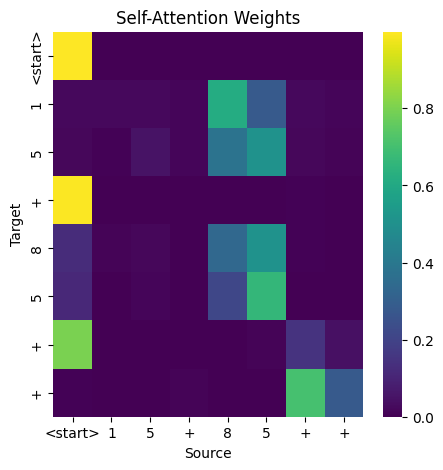

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
multi_attention: 
[[3.02122966e-10 3.62873106e-04 6.92705959e-02 8.43310773e-01
  8.68624225e-02 1.90680395e-04 6.54590508e-07 1.14639499e-06
  8.80797472e-07]
 [5.06111741e-01 5.90695329e-02 1.03170037e-01 1.28949275e-02
  4.68003191e-02 1.65089639e-03 2.74623539e-02 1.75936982e-01
  6.69032186e-02]
 [9.88644481e-01 5.63700814e-06 1.00886587e-06 1.28207319e-06
  3.66812912e-07 1.12037912e-06 1.54076522e-04 3.06897491e-05
  1.11612361e-02]
 [4.53321598e-02 2.38413886e-05 2.47064736e-06 2.06144090e-04
  4.59576584e-02 7.94413611e-02 7.92868257e-01 2.47308407e-02
  1.14373052e-02]
 [7.93722793e-02 6.39009476e-02 1.53410686e-02 5.77482751e-05
  1.14564082e-05 1.55841917e-05 1.04493950e-03 8.38958621e-01
  1.29740406e-03]
 [9.92495298e-01 3.70246213e-04 4.60189767e-05 5.60558965e-06
  5.81259030e-07 3.57358408e-06 1.588

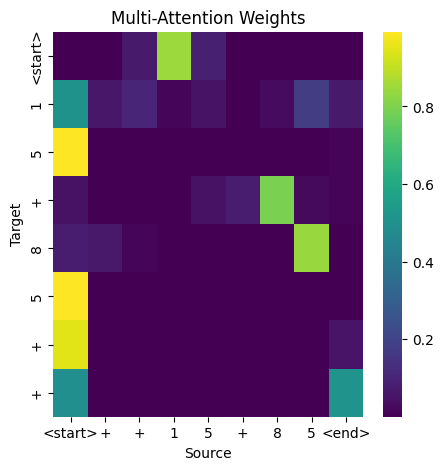

output.shape: torch.Size([1, 15])
output: tensor([[ 1.7923, -9.9299,  3.0123, -3.0985, -5.3873, -4.6569, -6.8280, -0.1033, -7.8579, -4.1145,
          0.8004, -0.5301, -4.0318, 15.7117,  3.1880]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: ++15+85
Decoded sequence: 15+85++


In [65]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Multi-Attention Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

tensor([[-0.0858, -0.2349],
        [-0.1135,  0.1410],
        [ 0.3057, -0.1128],
        [ 0.1792, -0.1608],
        [ 0.2908,  0.0738],
        [ 0.1181, -0.0150],
        [ 0.0941,  0.2265],
        [-0.1521, -0.1248],
        [-0.2821, -0.0702],
        [-0.0449, -0.0122],
        [ 0.1929, -0.5026],
        [ 0.4938, -0.0872],
        [-0.0155,  0.0869],
        [-0.4712,  0.0366],
        [-0.1505,  0.4533]])


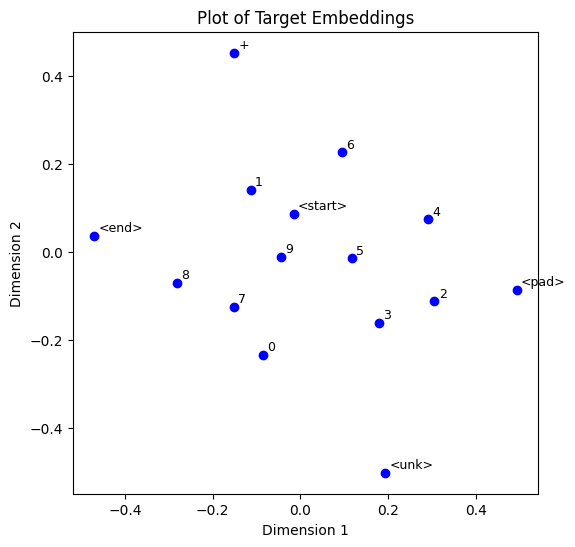

In [35]:
import numpy as np
embedding_cpu_01dim = embedding_weight.cpu().detach()[: , :2]
print(embedding_cpu_01dim)

reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

def plot_embedding_tgt_2d(ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))

    # 事前Embedding
    for i, (x, y) in enumerate(embedding_cpu_01dim):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 

    if tgt_embed is not None:
        tgt_embed = tgt_embed.detach().cpu().numpy()
        print(tgt_embed)
        print(tgt_embed.shape)
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=1)
        tgt_embed_2d = tgt_embed[:, :2]
        print(tgt_embed_2d)
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i)+label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


plot_embedding_tgt_2d()

text: + + 1 5 + 8 5
memory: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.2395,  2.3537, -1.3705, -0.7531,  1.1791,  2.3617, -0.4042, -1.9595,  3.9489,  2.7197,
           3.4515,  0.3252, -1.9478,  3.5909, -1.9810,  1.0457]],

        [[ 1.6809, -2.4267,  0.1701,  1.8847, -0.5263,  0.4241, -0.8065,  1.7959,  1.3026,  2.1360,
           1.4974,  0.2910, -0.3057,  0.6599, -1.5377,  0.1682]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
           3.4579,  0.3252, -1.9458,  3.5909, -1.9804,  1.0457]],

        [[ 0.0148, -2.6642,  0.5325,  1.3793, -0.3356,  0.3651, -0.7435,  1.7900,  1.3226,  2.1354,
           1.5037,  0.2910, -0.3037,  0.6599, -1.5371,  0.1682]],

        [[-1.4129,  0.8478,  0.7993, -0.7412,  0.7407,  3.5783,  3.2450,  1.7067, -0.7604,  0.4600,
           1.0339, -0.4176, -2.5009, 

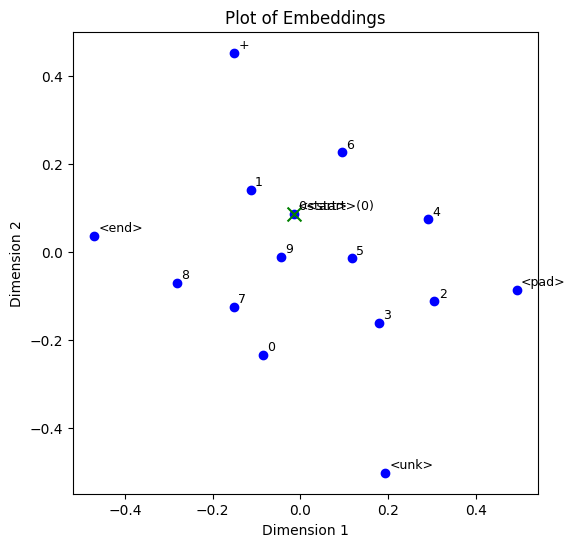

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]]
(1, 1, 16)
[[-0.06217712  1.347655  ]]


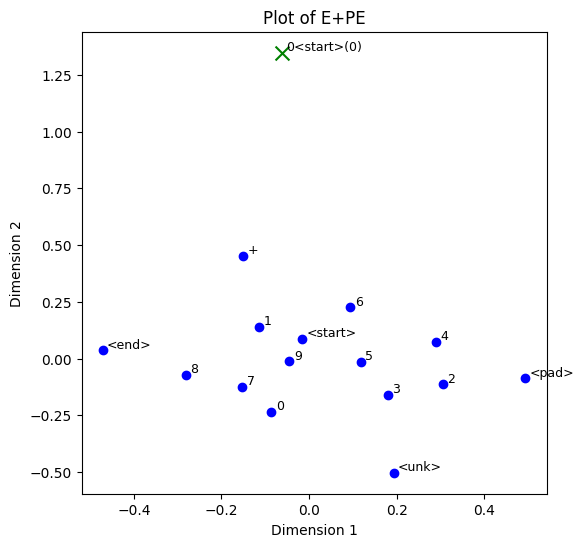

SelfAttention Layer
QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 1, 16])
WV.shape: torch.Size([1, 1, 16])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 16])
[[[ 2.906429    1.3423407  -0.96343255 -0.62139076  1.8523715
    2.0984704   1.7679657  -0.3866255   0.05640849 -2.2742298
   -0.3916857  -0.8873969   0.2616972  -1.8686377   0.07903923
   -3.3780906 ]]]
(1, 1, 16)
[[2.906429  1.3423407]]


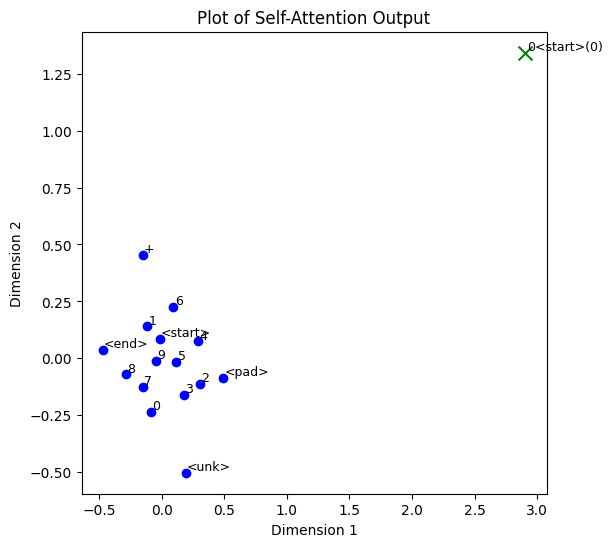

[[[ 1.706031    1.2083415  -0.4583757   0.9395603  -1.0970447
    1.0288606   1.7727534   0.5319681  -0.12319442 -1.1720741
   -0.99899024  0.3432288  -0.38349828 -1.9783328   0.59052217
   -1.1184115 ]]]
(1, 1, 16)
[[1.706031  1.2083415]]


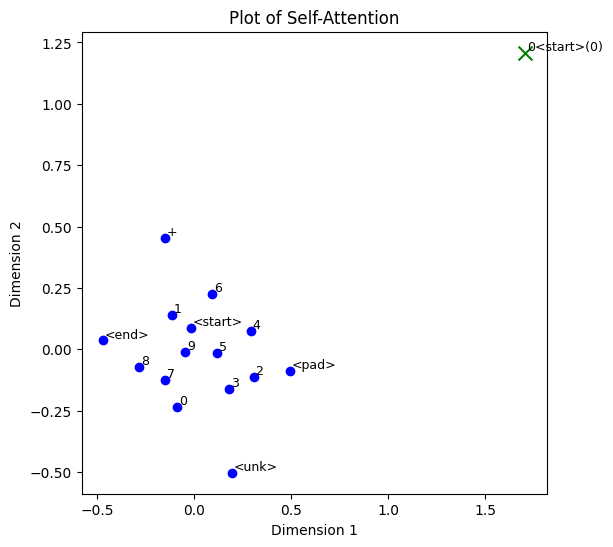

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 16])
After Attention: tensor([[[-0.9689, -0.3719, -1.1952, -0.0577,  3.0266, -3.3073, -0.8287,  3.5863, -4.6873, -0.2333,
          -1.6286,  1.3612,  4.5681, -0.2786, -0.2301,  1.2686]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-2.1770303  -1.5225327  -0.12136128  0.32269257  4.7531185
   -4.778063   -1.8235766   3.3462622  -4.6105757   1.2574778
    0.10176544  2.2133703   5.82959     2.0831852  -0.7155174
    3.109046  ]]]
(1, 1, 16)
[[-2.1770303 -1.5225327]]


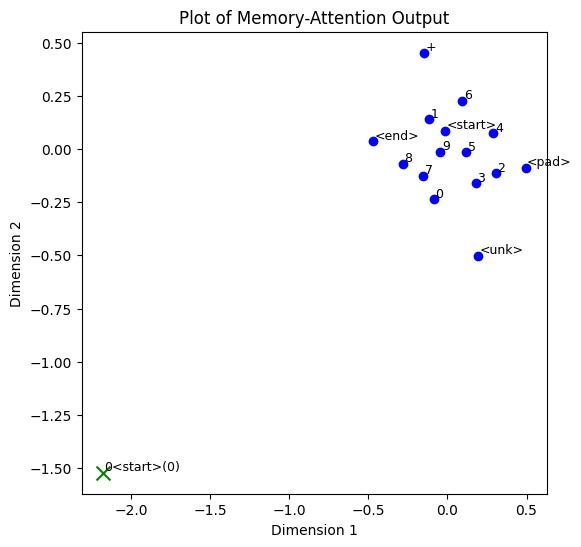

[[[-0.9688579  -0.3718981  -1.1951551  -0.05770751  3.0266316
   -3.3073473  -0.82869315  3.586253   -4.6872587  -0.23329906
   -1.6286237   1.3612047   4.5681143  -0.27863678 -0.2300627
    1.2685885 ]]]
(1, 1, 16)
[[-0.9688579 -0.3718981]]


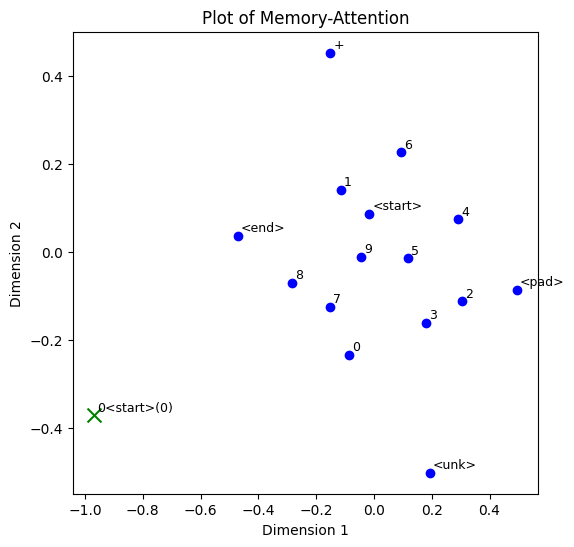

output.shape: torch.Size([1, 15])
output: tensor([[ 10.8289,  -5.1053,   9.0145,   3.4368,  -0.8385,  -3.9920,   0.6841,  -5.2227,  -3.6164,
           4.1041,  -2.0036,  -2.3229,  -0.4011,   1.7634, -10.9991]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[12],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]]], device='cuda:0')
now tgt: 0
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508

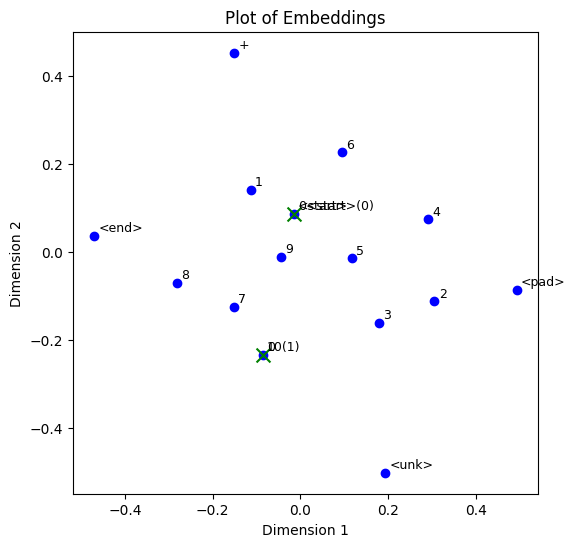

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]]
(2, 1, 16)
[[-0.06217712  1.347655  ]
 [ 0.49810314 -0.39948714]]


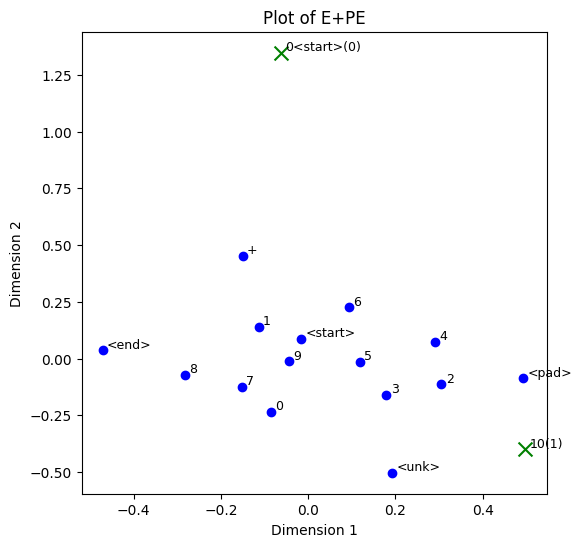

SelfAttention Layer
QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 2, 16])
WV.shape: torch.Size([1, 2, 16])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 16])
[[[ 2.906389    1.3423351  -0.9634518  -0.6213882   1.852394
    2.0984464   1.7679484  -0.38661763  0.05640746 -2.274207
   -0.39166474 -0.88739204  0.26167905 -1.8686393   0.07901321
   -3.3780649 ]]

 [[ 2.6089168   1.2998064  -1.1027018  -0.60391694  2.0185857
    1.9221685   1.641938   -0.32930467  0.0509698  -2.1043391
   -0.23563668 -0.8509127   0.12713505 -1.8772467  -0.11894865
   -3.183338  ]]]
(2, 1, 16)
[[2.906389  1.3423351]
 [2.6089168 1.2998064]]


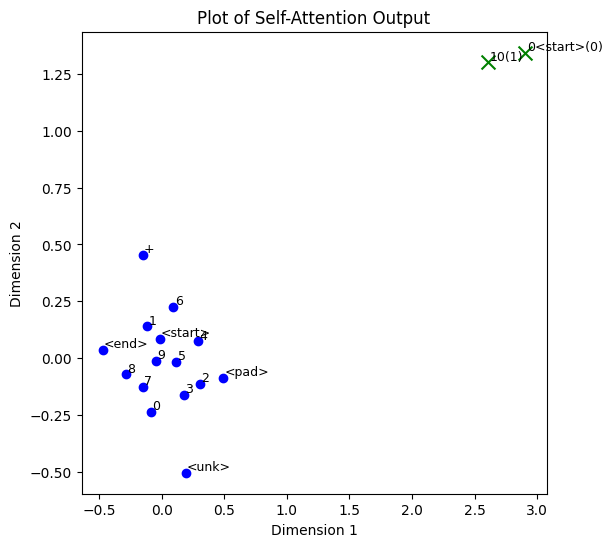

[[[ 1.7060088   1.2083468  -0.45838624  0.93956876 -1.0970356
    1.0288548   1.7727556   0.5319766  -0.12319437 -1.1720669
   -0.99898595  0.3432351  -0.38350874 -1.9783442   0.59051406
   -1.1184018 ]]

 [[ 1.8165531   0.17445473 -0.69667935 -0.2845178   1.8855292
    0.7475342  -0.19141811  1.0655962  -1.1636188  -0.19480065
   -0.06489087 -0.02533909  0.9157368  -1.956766    0.31022
   -1.7902293 ]]]
(2, 1, 16)
[[1.7060088  1.2083468 ]
 [1.8165531  0.17445473]]


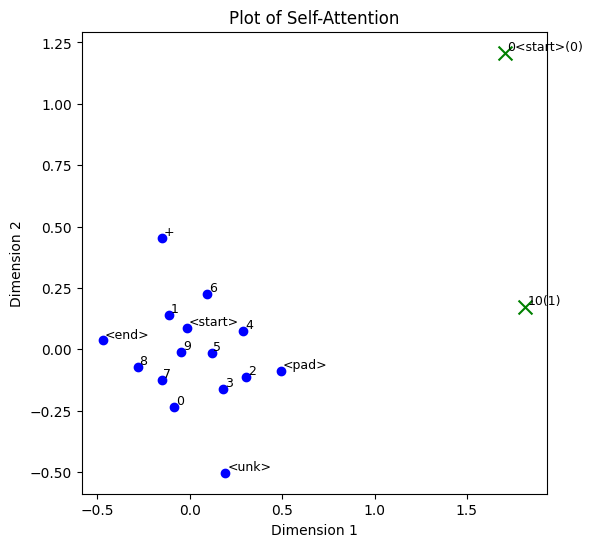

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 16])
After Attention: tensor([[[-0.9689, -0.3719, -1.1952, -0.0577,  3.0266, -3.3074, -0.8287,  3.5863, -4.6872, -0.2333,
          -1.6286,  1.3612,  4.5681, -0.2786, -0.2301,  1.2686]],

        [[-1.1932, -0.8447, -0.6708, -0.6681,  3.9289, -2.4736, -0.8107,  2.9990, -4.7639,  0.8301,
          -0.4759,  0.9083,  4.7395, -0.7238, -0.5336,  0.1151]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-2.1770122  -1.5225202  -0.12137498  0.32268995  4.7531195
   -4.778057   -1.8235893   3.3462477  -4.6105523   1.2574627
    0.10176536  2.2133694   5.8295727   2.0832067  -0.7155239
    3.1090484 ]]

 [[-2.8924432  -1.752147    0.58648217  0.2930243   3.7161021
   -4.220256   -0.03840615  2.642525   -4.6778626   2.045438
    0.27826756  2.017807    5.5097656   1.3024251  -1.2541722
    2.311882  ]]]
(2, 1,

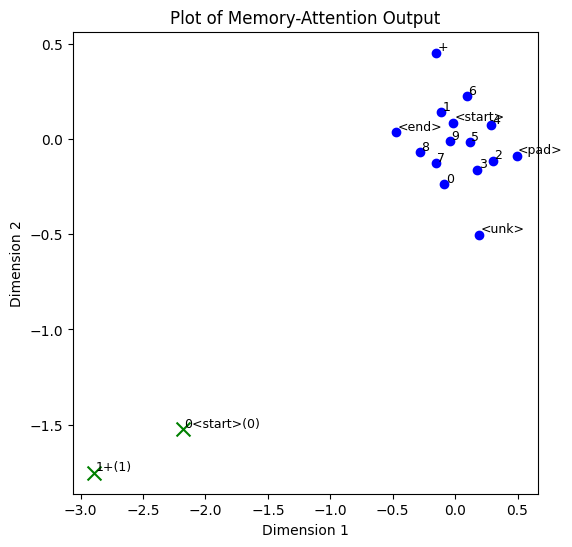

[[[-0.9688621  -0.37188902 -1.1951761  -0.05770319  3.0266428
   -3.3073537  -0.8287056   3.5862536  -4.687247   -0.23330434
   -1.6286218   1.361211    4.5680985  -0.27862817 -0.23007165
    1.2686013 ]]

 [[-1.1932002  -0.84473217 -0.6708178  -0.66813076  3.9289243
   -2.47365    -0.8107478   2.9990294  -4.763882    0.83010805
   -0.4759169   0.90828735  4.739487   -0.72375333 -0.53361315
    0.11508337]]]
(2, 1, 16)
[[-0.9688621  -0.37188902]
 [-1.1932002  -0.84473217]]


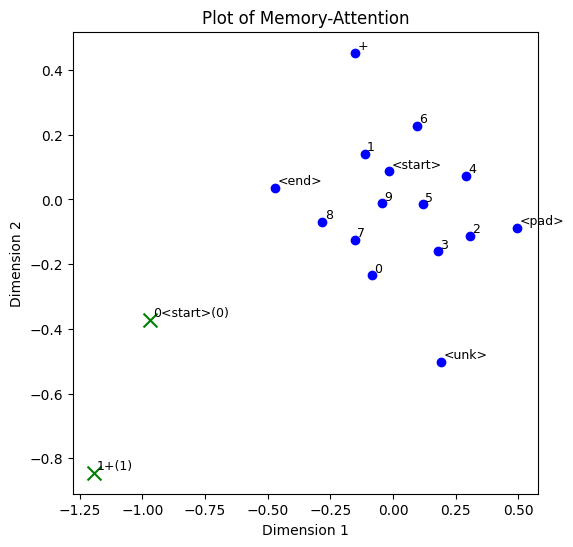

output.shape: torch.Size([1, 15])
output: tensor([[11.7788, -3.6000,  7.0311,  2.9871, -1.6081, -4.7236,  0.1305, -3.5659, -2.0791,  4.3862,
         -1.2607, -2.5523, -2.4502,  0.8982, -8.9621]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 2
ys: tensor([[12],
        [ 0],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]],

        [[ 0.5659, -1.3559,  0.3069,  0.3666,  2.4281,  0.3458, -1.2469,  4.0490, -2.1772,  2.3507,
           0.5581,  1.9625,  2.5452, -1.1528,  1.5895,  0.3288]]], device='cuda:0')
now tgt: 00
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
     

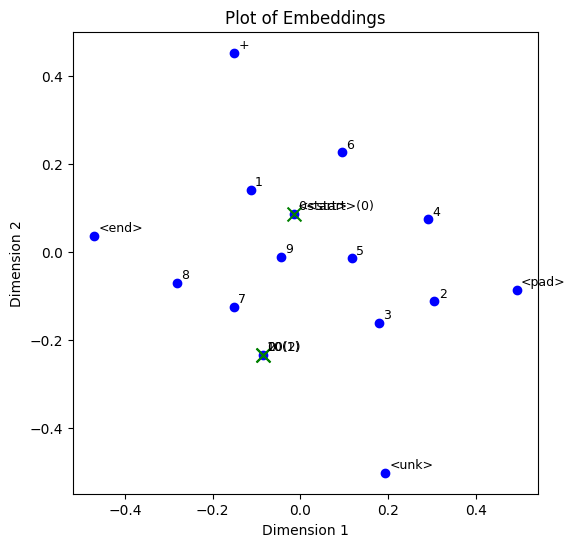

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]

 [[ 0.5659296  -1.3559363   0.30688044  0.3666072   2.4280643
    0.34576255 -1.2468703   4.0490212  -2.1771686   2.3506796
    0.5580593   1.9624902   2.5451977  -1.1528378   1.5894874
    0.32882518]]]
(3, 1, 16)
[[-0.06217712  1.347655  ]
 [ 0.49810314 -0.39948714]
 [ 0.5659296  -1.3559363 ]]


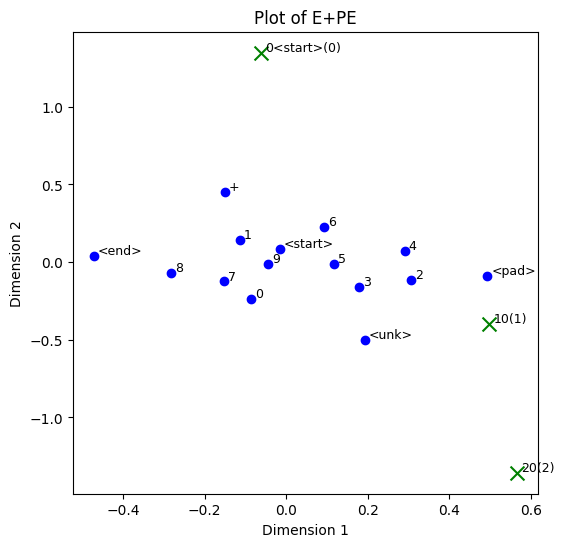

SelfAttention Layer
QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 3, 16])
WV.shape: torch.Size([1, 3, 16])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 16])
[[[ 2.906192    1.3423029  -0.9635388  -0.62139326  1.8525012
    2.0983522   1.7678893  -0.3865748   0.05640117 -2.2741098
   -0.39157984 -0.88736105  0.26158634 -1.8686619   0.07887541
   -3.3779564 ]]

 [[ 1.5779492   1.1295815  -1.5582912  -0.6332802   2.5790918
    1.4347136   1.3380858  -0.10466391  0.01784075 -1.5968432
    0.20492387 -0.6860767  -0.35740092 -1.9977576  -0.84093195
   -2.6203573 ]]

 [[-0.5467548   0.78998667 -2.5104854  -0.6496103   3.7418346
    0.36944678  0.64658916  0.3455144  -0.0434155  -0.5110396
    1.1621035  -0.36524236 -1.3470109  -2.2015567  -2.3112159
   -1.4051342 ]]]
(3, 1, 16)
[[ 2.906192    1.3423029 ]
 [ 1.5779492   1.1295815 ]
 [-0.5467548   0.78998667]]


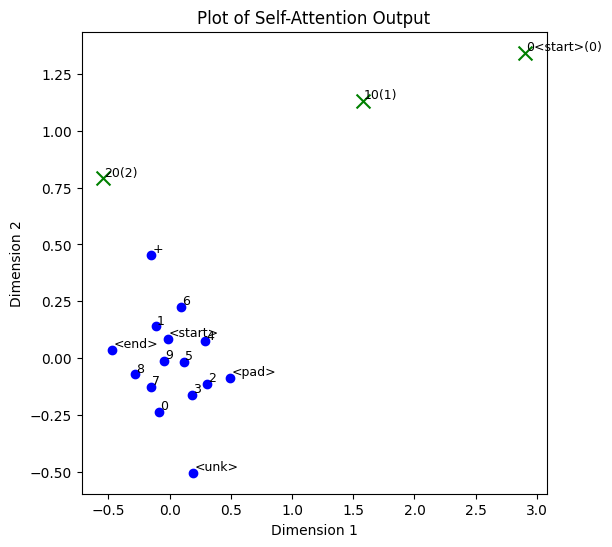

[[[ 1.7058921   1.2083663  -0.45843145  0.93959665 -1.0969875
    1.0288368   1.7727753   0.532018   -0.12319328 -1.1720332
   -0.9989668   0.3432675  -0.38355884 -1.9783981   0.5904676
   -1.1183571 ]]

 [[ 1.1161661   0.12913966 -0.85807586 -0.26194617  2.2620044
    0.55582106 -0.311262    1.2025539  -1.1607292   0.09593411
    0.14597583  0.0654247   0.75710833 -2.006358    0.03232284
   -1.4862274 ]]

 [[-0.281194   -0.422805   -0.93834174 -0.20017365  2.7362688
    0.0960946  -0.49801624  1.2998452  -0.98062223  0.6667954
    0.5664526   0.21013144  0.38565773 -1.8047407  -0.4783262
   -0.67639774]]]
(3, 1, 16)
[[ 1.7058921   1.2083663 ]
 [ 1.1161661   0.12913966]
 [-0.281194   -0.422805  ]]


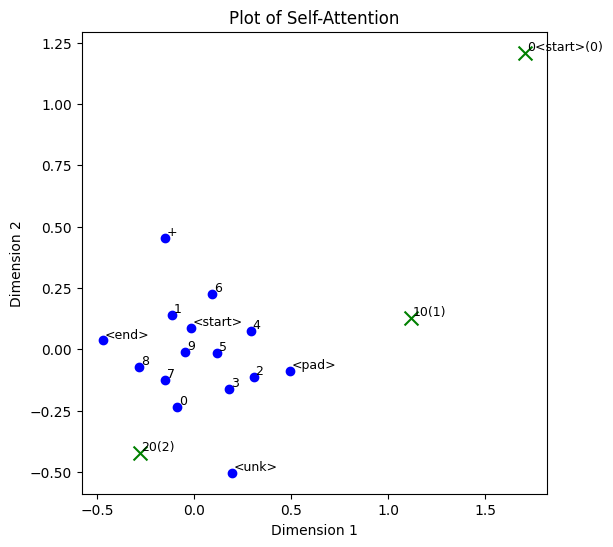

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 16])
After Attention: tensor([[[-9.6888e-01, -3.7184e-01, -1.1953e+00, -5.7691e-02,  3.0267e+00, -3.3074e+00, -8.2876e-01,
           3.5862e+00, -4.6872e+00, -2.3334e-01, -1.6286e+00,  1.3612e+00,  4.5680e+00, -2.7858e-01,
          -2.3012e-01,  1.2687e+00]],

        [[-1.7698e+00, -5.3998e-01,  6.3267e-04, -6.2708e-01,  2.5743e+00, -6.9659e-01,  6.6462e+00,
          -9.6554e-01, -2.8969e+00,  1.9027e+00, -8.5363e-01,  5.7574e-01,  3.5778e+00, -2.5286e+00,
          -1.5891e+00, -1.1486e+00]],

        [[-1.3740e-01,  1.4111e+00, -1.0909e+00, -1.1212e+00,  1.2520e+00,  1.4812e+00, -1.0138e+00,
          -4.3957e+00,  4.8045e+00, -6.8668e-02,  2.3530e+00, -3.1539e-01, -2.6296e+00,  2.2803e+00,
          -1.3123e+00, -1.8824e+00]]], device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
[[[-2.1769125  -1.5224504  -0.1

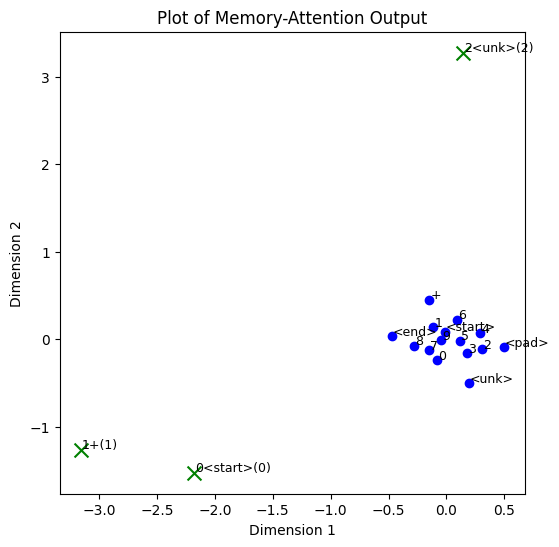

[[[-9.6888155e-01 -3.7184393e-01 -1.1952825e+00 -5.7690591e-02
    3.0267100e+00 -3.3073776e+00 -8.2876420e-01  3.5862498e+00
   -4.6871858e+00 -2.3333792e-01 -1.6286184e+00  1.3612431e+00
    4.5680242e+00 -2.7857915e-01 -2.3012047e-01  1.2686657e+00]]

 [[-1.7697793e+00 -5.3998399e-01  6.3267146e-04 -6.2707585e-01
    2.5742712e+00 -6.9659287e-01  6.6461678e+00 -9.6554363e-01
   -2.8969388e+00  1.9026939e+00 -8.5362911e-01  5.7573849e-01
    3.5777757e+00 -2.5286252e+00 -1.5890552e+00 -1.1485819e+00]]

 [[-1.3740367e-01  1.4110852e+00 -1.0908701e+00 -1.1211880e+00
    1.2520007e+00  1.4811668e+00 -1.0137519e+00 -4.3956618e+00
    4.8045468e+00 -6.8667784e-02  2.3529747e+00 -3.1539035e-01
   -2.6296217e+00  2.2802932e+00 -1.3122926e+00 -1.8824096e+00]]]
(3, 1, 16)
[[-0.96888155 -0.37184393]
 [-1.7697793  -0.539984  ]
 [-0.13740367  1.4110852 ]]


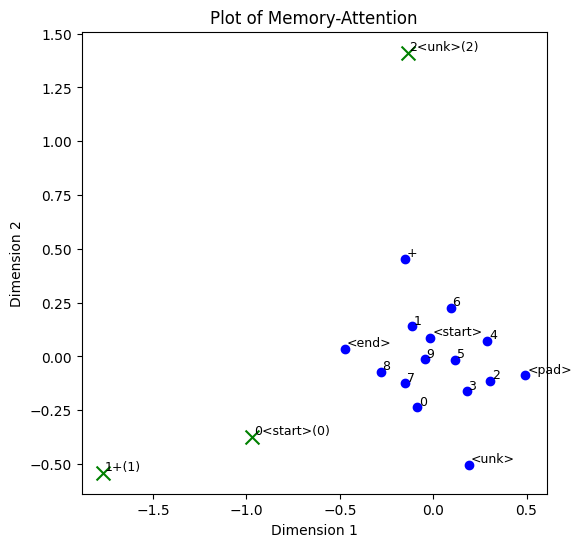

output.shape: torch.Size([1, 15])
output: tensor([[-8.1950, -0.2037, -6.3025, -5.8036, -0.2807,  4.8828,  2.4290,  2.1543,  1.6220, -1.3629,
          1.3462, -0.4751, -6.0150,  0.4250, 15.9725]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 3
ys: tensor([[12],
        [ 0],
        [ 0],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]],

        [[ 0.5659, -1.3559,  0.3069,  0.3666,  2.4281,  0.3458, -1.2469,  4.0490, -2.1772,  2.3507,
           0.5581,  1.9625,  2.5452, -1.1528,  1.5895,  0.3288]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
           3.4579,  0.3252, -1

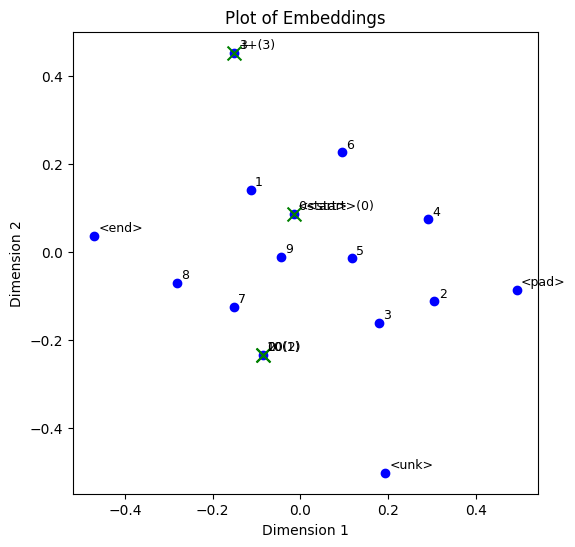

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]

 [[ 0.5659296  -1.3559363   0.30688044  0.3666072   2.4280643
    0.34576255 -1.2468703   4.0490212  -2.1771686   2.3506796
    0.5580593   1.9624902   2.5451977  -1.1528378   1.5894874
    0.32882518]]

 [[-0.46088833  0.8233893  -0.86880255 -1.1207919   1.3748227
    2.3220494  -0.34105128 -1.9635267   3.9689047   2.7193384
    3.457872    0.32516986 -1.9457606   3.590855   -1.9804164
    1.0456802 ]]]
(4, 1, 16)
[[-0.06217712  1.347655  ]
 [ 0.49810314 -0.39948714]
 [ 0.5659296  -1.3559363 ]
 [-0.46088833  0.8233893 ]]


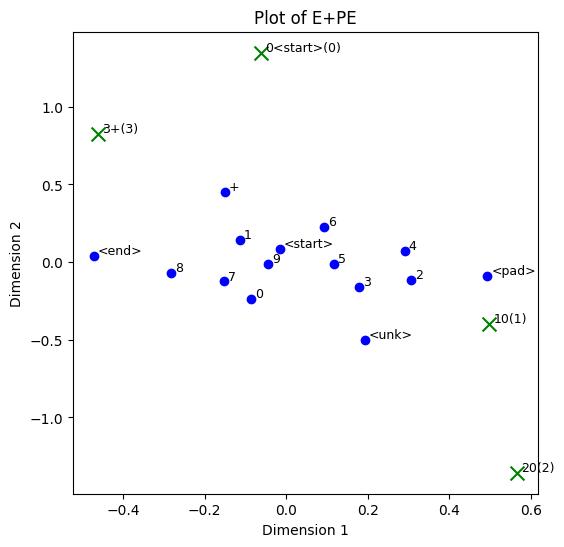

SelfAttention Layer
QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 4, 16])
WV.shape: torch.Size([1, 4, 16])
attn_weight.shape: torch.Size([1, 4, 4])
AV.shape: torch.Size([1, 4, 16])
[[[ 2.906192    1.3423029  -0.9635388  -0.62139326  1.8525012
    2.0983522   1.7678893  -0.3865748   0.05640117 -2.2741098
   -0.39157984 -0.88736105  0.26158634 -1.8686619   0.07887541
   -3.3779564 ]]

 [[ 1.5670185   1.1235827  -1.5580378  -0.6095706   2.5689843
    1.4083303   1.3213582  -0.10595345  0.00892829 -1.5835713
    0.21157482 -0.6985161  -0.35299608 -1.99085    -0.8282475
   -2.5940342 ]]

 [[-0.5925028   0.75286126 -2.494855   -0.4831064   3.6540432
    0.19992504  0.53934413  0.32992277 -0.10502354 -0.43376046
    1.1948217  -0.4571401  -1.3017263  -2.1501503  -2.2008786
   -1.2382153 ]]

 [[ 2.9055967   1.3419875  -0.96353894 -0.62014925  1.8519888
    2.0969536   1.7669977  -0.38663897  0.05593663 -2.2733977
   -0.3912135  -0.8880096   0.26180613 -1.8682965   0.07952248
   -3.

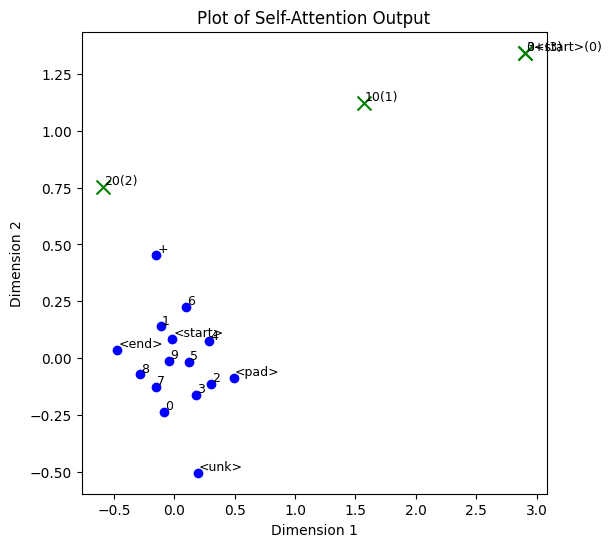

[[[ 1.7058921   1.2083663  -0.45843145  0.93959665 -1.0969875
    1.0288368   1.7727753   0.532018   -0.12319328 -1.1720332
   -0.9989668   0.3432675  -0.38355884 -1.9783981   0.5904676
   -1.1183571 ]]

 [[ 1.1104058   0.12587725 -0.86016864 -0.2506604   2.2622077
    0.5437666  -0.32105288  1.2051595  -1.167492    0.10265091
    0.14877892  0.0615657   0.76065326 -2.0076632   0.0380873
   -1.4764141 ]]

 [[-0.31818053 -0.4480732  -0.94315284 -0.12669906  2.7195256
    0.01754683 -0.55657953  1.306853   -1.0154873   0.7064849
    0.58205247  0.18342856  0.40523568 -1.7993277  -0.4394427
   -0.606747  ]]

 [[ 1.2368841   0.8279021  -0.8941181  -0.9935713   1.2098901
    1.6855392   0.36187124 -1.0959677   1.3116107  -0.06393651
    0.9698066  -0.5528858  -0.8319898   0.46258587 -1.0507655
   -1.3721347 ]]]
(4, 1, 16)
[[ 1.7058921   1.2083663 ]
 [ 1.1104058   0.12587725]
 [-0.31818053 -0.4480732 ]
 [ 1.2368841   0.8279021 ]]


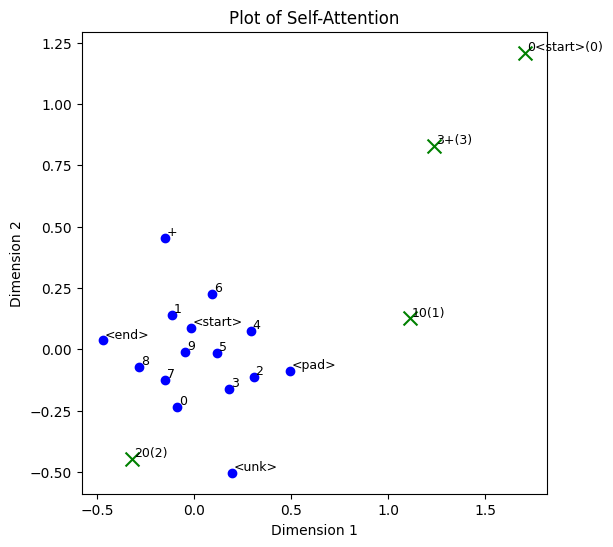

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 16])
After Attention: tensor([[[-0.9689, -0.3718, -1.1953, -0.0577,  3.0267, -3.3074, -0.8288,  3.5862, -4.6872, -0.2333,
          -1.6286,  1.3612,  4.5680, -0.2786, -0.2301,  1.2687]],

        [[-1.7756, -0.5366, -0.0132, -0.6246,  2.5979, -0.7295,  6.6063, -0.9788, -2.8930,  1.9073,
          -0.8399,  0.5821,  3.5962, -2.5083, -1.5993, -1.1467]],

        [[-0.3082,  1.4309, -1.1362, -1.1627,  1.1913,  1.5279, -0.7694, -4.3062,  4.4652, -0.0815,
           3.1588, -0.5497, -2.7623,  2.1382, -1.2194, -1.7821]],

        [[-0.9051,  0.2903, -0.0404, -1.3281,  0.7165,  3.2676,  7.6507, -1.1177, -0.9978,  0.6758,
           2.8945, -1.7741, -1.4009, -2.6530, -0.4389, -1.7439]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
[[[-2.1769125  -1.5224504  -0.12145223  0.322675    4.7531333
   -4.778025   -1

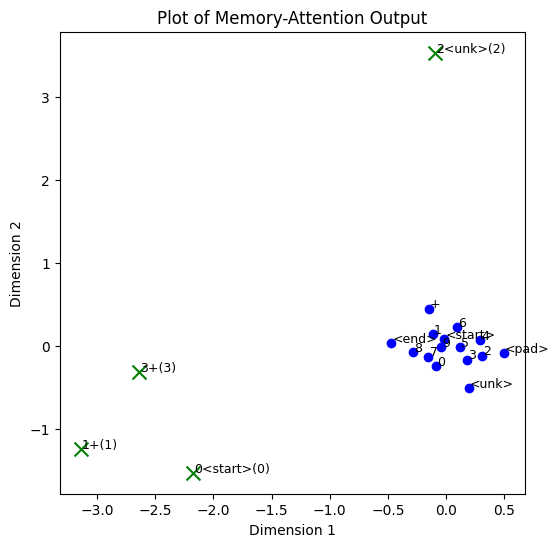

[[[-0.96888155 -0.37184393 -1.1952825  -0.05769059  3.02671
   -3.3073776  -0.8287642   3.5862498  -4.687186   -0.23333792
   -1.6286184   1.3612431   4.568024   -0.27857915 -0.23012047
    1.2686657 ]]

 [[-1.7756451  -0.5366336  -0.01324886 -0.62462217  2.597903
   -0.72949123  6.606285   -0.97883177 -2.8930418   1.9072777
   -0.8398967   0.58214295  3.596166   -2.5082707  -1.5993413
   -1.1467164 ]]

 [[-0.30823725  1.430914   -1.1362191  -1.1626526   1.1912977
    1.5278723  -0.7694264  -4.306184    4.465213   -0.08149765
    3.1588054  -0.5497499  -2.7623062   2.138241   -1.21943
   -1.782057  ]]

 [[-0.90511066  0.29029688 -0.04044914 -1.3280883   0.7164636
    3.2675543   7.6506524  -1.1176625  -0.9977836   0.67576426
    2.8944812  -1.7740936  -1.400918   -2.6529596  -0.43887234
   -1.7439116 ]]]
(4, 1, 16)
[[-0.96888155 -0.37184393]
 [-1.7756451  -0.5366336 ]
 [-0.30823725  1.430914  ]
 [-0.90511066  0.29029688]]


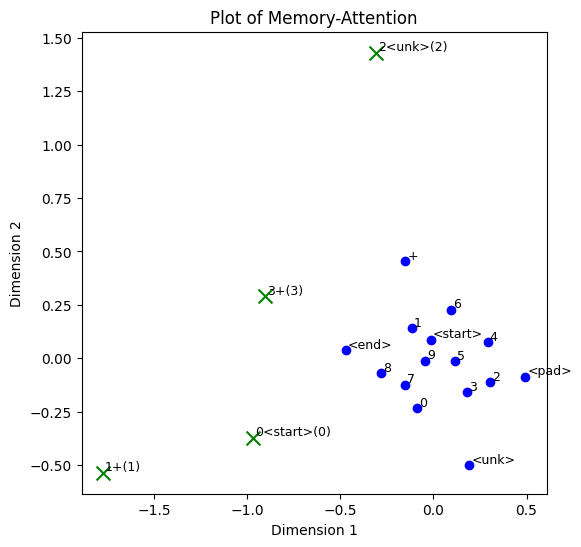

output.shape: torch.Size([1, 15])
output: tensor([[-1.9145, 13.3538, -4.2506, -0.9342, -3.7237, -6.4493,  2.1329,  0.6844,  9.0726,  1.0588,
         -1.0144,  0.2589,  0.4990, -8.8722,  3.4178]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 4
ys: tensor([[12],
        [ 0],
        [ 0],
        [14],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]],

        [[ 0.5659, -1.3559,  0.3069,  0.3666,  2.4281,  0.3458, -1.2469,  4.0490, -2.1772,  2.3507,
           0.5581,  1.9625,  2.5452, -1.1528,  1.5895,  0.3288]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
           3.4579

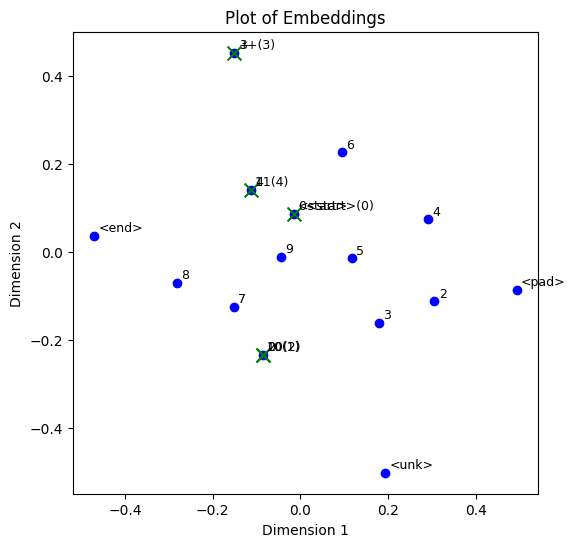

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]

 [[ 0.5659296  -1.3559363   0.30688044  0.3666072   2.4280643
    0.34576255 -1.2468703   4.0490212  -2.1771686   2.3506796
    0.5580593   1.9624902   2.5451977  -1.1528378   1.5894874
    0.32882518]]

 [[-0.46088833  0.8233893  -0.86880255 -1.1207919   1.3748227
    2.3220494  -0.34105128 -1.9635267   3.9689047   2.7193384
    3.457872    0.32516986 -1.9457606   3.590855   -1.9804164
    1.0456802 ]]

 [[-1.210825   -0.08949375  0.7529472  -0.42974535  0.6506746
    3.6217713   3.2136846   1.7112185  -0.7703686   0.46043378
    1.0307511  -0.4175738  -2.5019457  -2.167472    1.775966

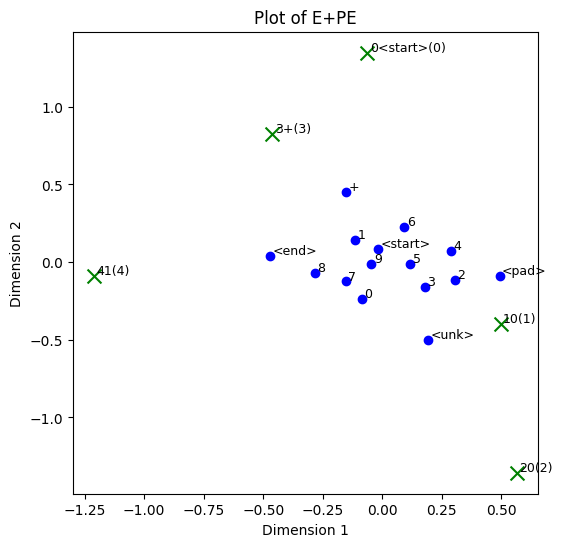

SelfAttention Layer
QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 5, 16])
WV.shape: torch.Size([1, 5, 16])
attn_weight.shape: torch.Size([1, 5, 5])
AV.shape: torch.Size([1, 5, 16])
[[[ 2.8998005   1.3416196  -0.9602117  -0.61647135  1.854724
    2.0896444   1.7571563  -0.39361605  0.06256951 -2.266699
   -0.3836148  -0.87941474  0.2649873  -1.8573287   0.06684388
   -3.357221  ]]

 [[ 0.7012156   1.0985941   0.04850386  0.96940464  2.6457
   -0.78652805 -1.7453555  -2.6310148   2.0434973   0.19171569
    2.2441373   1.6987468   1.2952967   1.778407   -3.9020214
    3.4010782 ]]

 [[ 0.50505334  1.0685111   0.02098905  1.0252893   2.7338533
   -0.9459822  -1.8963718  -2.6698523   2.0935788   0.334341
    2.3810465   1.787503    1.2680514   1.875291   -4.1000137
    3.6826053 ]]

 [[ 2.90559     1.3419871  -0.9635356  -0.6201443   1.8519908
    2.096945    1.7669873  -0.38664606  0.05594284 -2.2733903
   -0.39120555 -0.8880016   0.26180968 -1.8682851   0.07951038
   -3.376539

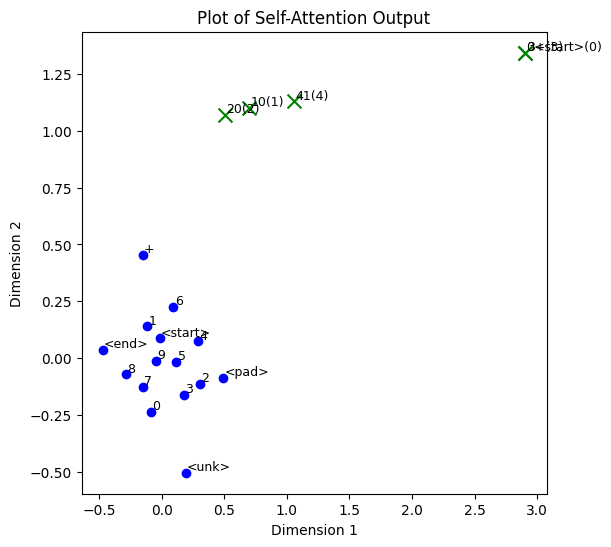

[[[ 1.7045418   1.2107289  -0.45941266  0.94429535 -1.1005421
    1.0263718   1.7712339   0.5301903  -0.12160195 -1.173088
   -0.9999443   0.34753558 -0.38442564 -1.9795198   0.5854684
   -1.1111203 ]]

 [[-0.09929764 -0.2721387  -0.48125672  0.20439728  1.8917745
   -0.9175462  -2.2996163  -0.02649144 -0.5864815   0.6266877
    0.6793872   0.64619243  1.1515025  -0.39409298 -1.6149642
    1.2296587 ]]

 [[-0.16383621 -0.7510973  -0.3479392   0.17322668  1.9003645
   -0.9393917  -2.2234838  -0.03138631 -0.51812255  0.6761465
    0.7135406   0.64341563  1.0978025  -0.31281605 -1.6004839
    1.3161201 ]]

 [[ 1.2368788   0.82790136 -0.89411795 -0.99357045  1.2098908
    1.6855353   0.3618654  -1.0959712   1.3116131  -0.06393413
    0.9698092  -0.55288404 -0.83198965  0.46259055 -1.0507717
   -1.3721268 ]]

 [[-1.0510777   0.28337055 -0.06558436 -0.21477468  1.8065331
    1.8023529   0.9598419  -0.7998949   0.11710378 -0.33765197
    1.3105015  -0.14004526 -1.2638894  -1.3667797  -1.45293

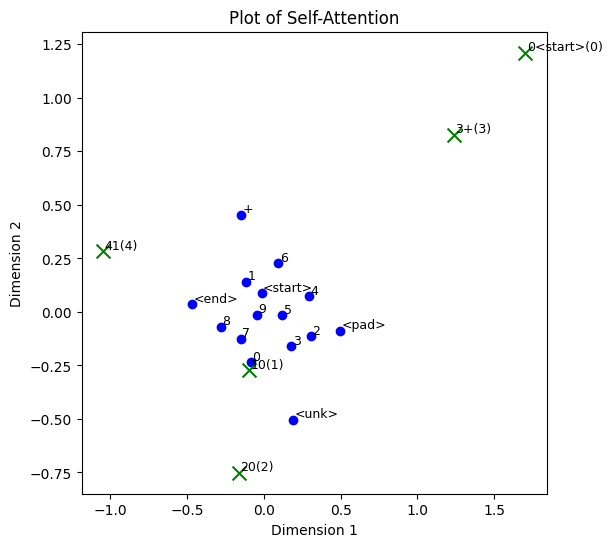

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 16])
After Attention: tensor([[[-0.9681, -0.3696, -1.1980, -0.0552,  3.0250, -3.3099, -0.8331,  3.5830, -4.6844, -0.2355,
          -1.6296,  1.3645,  4.5663, -0.2763, -0.2340,  1.2752]],

        [[-0.4522,  1.4246, -0.8985, -1.1203,  0.7013,  1.1081, -1.4185, -4.6917,  3.7459, -0.1535,
           4.2659, -0.6944, -2.3615,  2.4853, -1.4133, -0.6004]],

        [[-0.4811,  1.2686, -0.8293, -1.1306,  0.7074,  1.1019, -1.3633, -4.7029,  3.7959, -0.1316,
           4.3012, -0.6949, -2.3941,  2.5400, -1.4097, -0.5541]],

        [[-0.9051,  0.2903, -0.0405, -1.3281,  0.7165,  3.2676,  7.6506, -1.1177, -0.9978,  0.6758,
           2.8945, -1.7741, -1.4009, -2.6530, -0.4389, -1.7439]],

        [[ 0.8749,  0.2861,  0.4291, -0.0238,  0.7207,  0.8045, -2.7379, -2.6472,  4.1144, -0.0362,
          -6.3680,  1.7060,  0.0707,  2

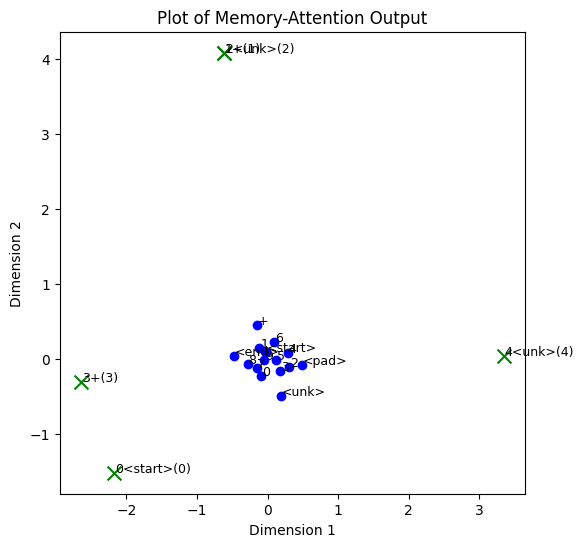

[[[-0.96811277 -0.36957625 -1.1979587  -0.0551597   3.0250497
   -3.3098993  -0.8331043   3.583024   -4.684386   -0.23549056
   -1.6296145   1.3645134   4.5663285  -0.2763318  -0.23399824
    1.2752234 ]]

 [[-0.45224994  1.424588   -0.89852417 -1.1203457   0.70125926
    1.1080643  -1.4185032  -4.6916914   3.7459495  -0.15351692
    4.2658534  -0.69442815 -2.3615484   2.4852672  -1.41332
   -0.600401  ]]

 [[-0.48109922  1.2685806  -0.82925004 -1.1306102   0.7074023
    1.1019279  -1.3632885  -4.7029347   3.7959352  -0.13156483
    4.301213   -0.6948808  -2.394099    2.5400255  -1.4097484
   -0.55410427]]

 [[-0.9051108   0.2902995  -0.04045071 -1.3280897   0.7164633
    3.2675571   7.6506453  -1.1176704  -0.9977738   0.675763
    2.894489   -1.7740954  -1.4009262  -2.6529524  -0.43887508
   -1.7439104 ]]

 [[ 0.8748672   0.28608912  0.42914438 -0.02376928  0.7207034
    0.8045012  -2.7378857  -2.647236    4.1143904  -0.03615601
   -6.367983    1.7059544   0.07073344  2.39103    -1.09

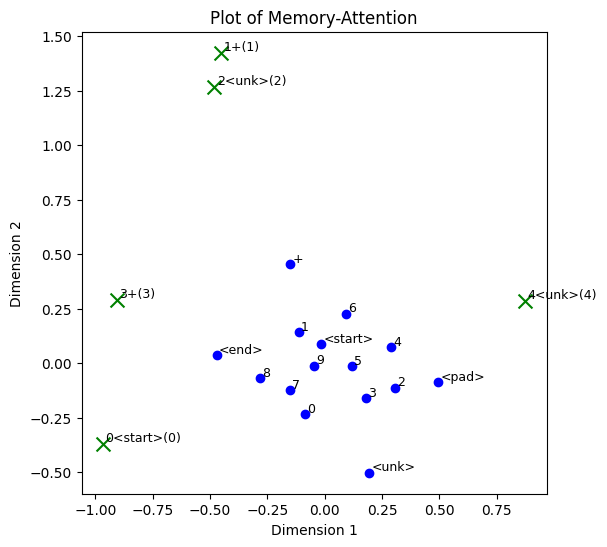

output.shape: torch.Size([1, 15])
output: tensor([[-5.3651, -7.3737,  2.6632,  1.7518,  3.5393, 14.9463,  1.2431,  2.3031,  2.9373,  2.6910,
         -1.2707, -1.5791, -1.4406, -2.0865,  2.8633]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[12],
        [ 0],
        [ 0],
        [14],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]],

        [[ 0.5659, -1.3559,  0.3069,  0.3666,  2.4281,  0.3458, -1.2469,  4.0490, -2.1772,  2.3507,
           0.5581,  1.9625,  2.5452, -1.1528,  1.5895,  0.3288]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.9689,  2.7193,
   

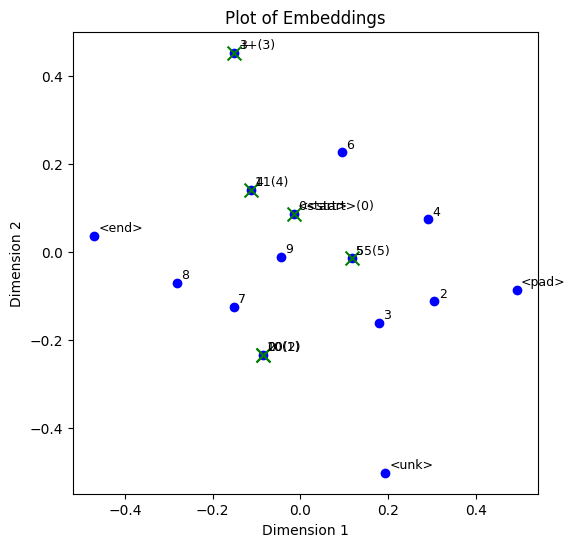

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]

 [[ 0.5659296  -1.3559363   0.30688044  0.3666072   2.4280643
    0.34576255 -1.2468703   4.0490212  -2.1771686   2.3506796
    0.5580593   1.9624902   2.5451977  -1.1528378   1.5894874
    0.32882518]]

 [[-0.46088833  0.8233893  -0.86880255 -1.1207919   1.3748227
    2.3220494  -0.34105128 -1.9635267   3.9689047   2.7193384
    3.457872    0.32516986 -1.9457606   3.590855   -1.9804164
    1.0456802 ]]

 [[-1.210825   -0.08949375  0.7529472  -0.42974535  0.6506746
    3.6217713   3.2136846   1.7112185  -0.7703686   0.46043378
    1.0307511  -0.4175738  -2.5019457  -2.167472    1.775966

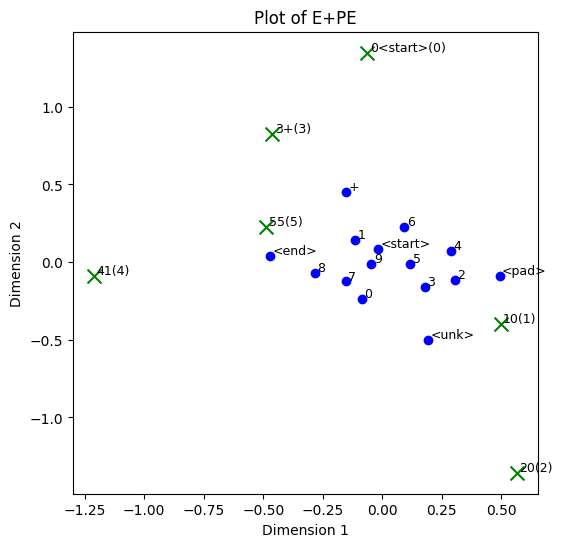

SelfAttention Layer
QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 6, 16])
WV.shape: torch.Size([1, 6, 16])
attn_weight.shape: torch.Size([1, 6, 6])
AV.shape: torch.Size([1, 6, 16])
[[[ 2.898752    1.3413106  -0.96077406 -0.61616176  1.8549097
    2.0887039   1.7566996  -0.39319834  0.06204695 -2.266425
   -0.3832729  -0.8796243   0.26444596 -1.8576146   0.06698968
   -3.3566103 ]]

 [[-0.15366371  0.7857793  -0.7402054   1.0802865   2.7365735
   -1.4169618  -1.7335881  -1.8207047   1.1528556   0.1314099
    2.2345374   1.0727519   0.52705413  0.9064136  -3.1380625
    3.072282  ]]

 [[-0.3847581   0.73612964 -0.82491773  1.1357487   2.8174896
   -1.5997694  -1.8591129  -1.7898595   1.1251433   0.24611332
    2.34842     1.0981159   0.44416776  0.91934705 -3.2441008
    3.2822921 ]]

 [[ 2.8985667   1.3399196  -0.96729714 -0.6180696   1.8532363
    2.0906425   1.7639219  -0.38385656  0.05244946 -2.2715468
   -0.38891026 -0.8893953   0.25818822 -1.8701874   0.08047543
   -3.3

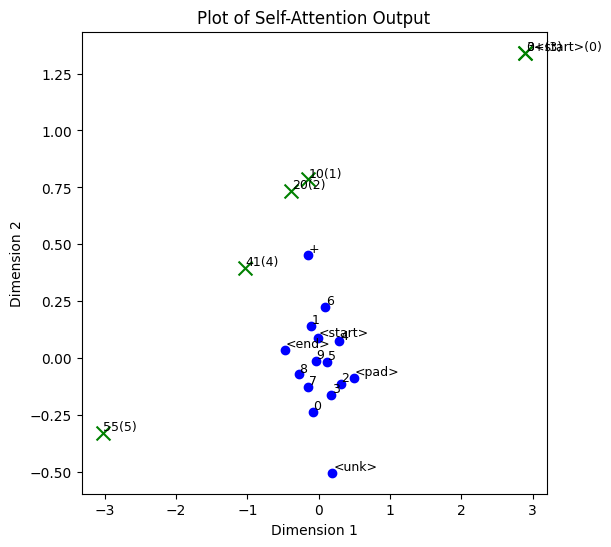

[[[ 1.7039204   1.210748   -0.45964757  0.9446592  -1.1004351
    1.0260196   1.7712289   0.530505   -0.12179355 -1.172958
   -0.99981725  0.34756738 -0.3846619  -1.9797889   0.5856877
   -1.1107734 ]]

 [[-0.5427101  -0.29494253 -0.68781227  0.39936846  2.0849528
   -1.0985093  -2.1527336   0.3794474  -0.8456329   0.73090875
    0.7848909   0.52446026  0.9417212  -0.7025479  -1.1626526
    1.2026007 ]]

 [[-0.5976071  -0.7782493  -0.5610166   0.37042764  2.1071813
   -1.1195273  -2.0759232   0.3894516  -0.79173076  0.77809924
    0.8188629   0.51978153  0.89169914 -0.63952184 -1.1327329
    1.276647  ]]

 [[ 1.2335211   0.82788175 -0.89566755 -0.992802    1.2117865
    1.6842216   0.3611396  -1.0952908   1.3114996  -0.06268564
    0.9715957  -0.55322695 -0.83355355  0.46251917 -1.0505953
   -1.3705935 ]]

 [[-2.167671    0.14990897 -0.59330636  0.405727    1.9506092
    0.8242147   1.0221905   0.37795854 -0.556185    0.07615545
    1.3912615  -0.4254679  -1.5414526  -1.8161846  -0.069

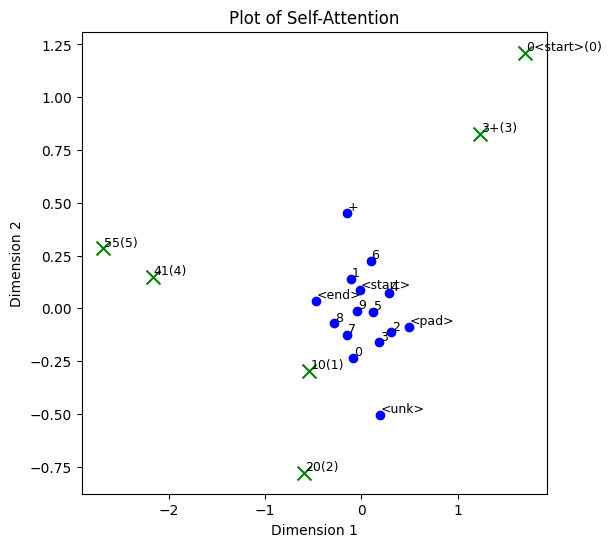

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 16])
After Attention: tensor([[[-9.6817e-01, -3.6935e-01, -1.1985e+00, -5.4980e-02,  3.0253e+00, -3.3102e+00, -8.3362e-01,
           3.5830e+00, -4.6841e+00, -2.3573e-01, -1.6295e+00,  1.3646e+00,  4.5659e+00, -2.7592e-01,
          -2.3403e-01,  1.2756e+00]],

        [[-6.7305e-01,  1.4523e+00, -1.0119e+00, -1.0624e+00,  7.8863e-01,  1.0307e+00, -1.3315e+00,
          -4.5186e+00,  3.7113e+00, -1.1077e-01,  4.4406e+00, -7.5768e-01, -2.5344e+00,  2.3733e+00,
          -1.2775e+00, -6.2518e-01]],

        [[-6.9907e-01,  1.2931e+00, -9.4571e-01, -1.0728e+00,  8.0122e-01,  1.0254e+00, -1.2761e+00,
          -4.5263e+00,  3.7608e+00, -8.9337e-02,  4.4843e+00, -7.6024e-01, -2.5704e+00,  2.4223e+00,
          -1.2698e+00, -5.8536e-01]],

        [[-9.0681e-01,  2.9089e-01, -4.1048e-02, -1.3280e+00,  7.1714e-01,  3.2664e+

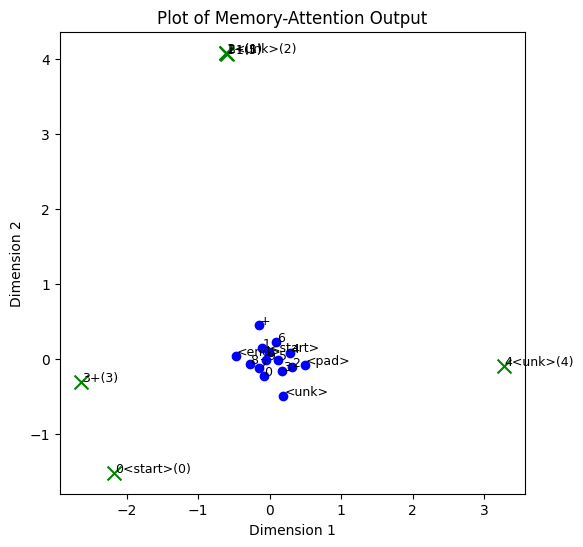

[[[-9.6816814e-01 -3.6934510e-01 -1.1985444e+00 -5.4979950e-02
    3.0252788e+00 -3.3102059e+00 -8.3362031e-01  3.5830207e+00
   -4.6841249e+00 -2.3572624e-01 -1.6295223e+00  1.3646001e+00
    4.5658565e+00 -2.7591571e-01 -2.3403071e-01  1.2756318e+00]]

 [[-6.7304593e-01  1.4523098e+00 -1.0119073e+00 -1.0624049e+00
    7.8862739e-01  1.0306818e+00 -1.3314861e+00 -4.5185661e+00
    3.7112849e+00 -1.1076618e-01  4.4406242e+00 -7.5767791e-01
   -2.5343590e+00  2.3733230e+00 -1.2774544e+00 -6.2517798e-01]]

 [[-6.9907397e-01  1.2931201e+00 -9.4570893e-01 -1.0728481e+00
    8.0121833e-01  1.0254188e+00 -1.2760900e+00 -4.5263462e+00
    3.7607729e+00 -8.9336708e-02  4.4843102e+00 -7.6023799e-01
   -2.5704465e+00  2.4222965e+00 -1.2698461e+00 -5.8536440e-01]]

 [[-9.0681052e-01  2.9088560e-01 -4.1047707e-02 -1.3279684e+00
    7.1714246e-01  3.2664230e+00  7.6525688e+00 -1.1238389e+00
   -9.9319512e-01  6.7743677e-01  2.8930678e+00 -1.7729762e+00
   -1.4012566e+00 -2.6498485e+00 -4.4155329e-0

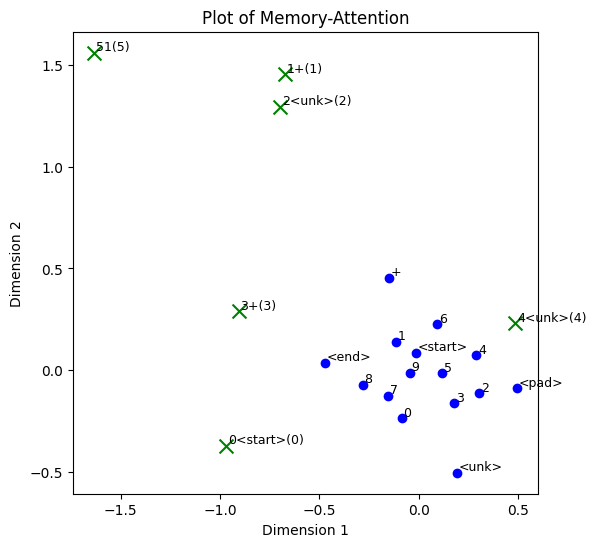

output.shape: torch.Size([1, 15])
output: tensor([[-8.5406,  0.3174, -6.4065, -6.2743, -1.5392,  2.6065,  1.4906,  1.9453,  0.9432, -2.7884,
          0.9490, -0.9276, -5.2330,  3.0237, 16.2755]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 6
ys: tensor([[12],
        [ 0],
        [ 0],
        [14],
        [ 1],
        [ 5],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]],

        [[ 0.5659, -1.3559,  0.3069,  0.3666,  2.4281,  0.3458, -1.2469,  4.0490, -2.1772,  2.3507,
           0.5581,  1.9625,  2.5452, -1.1528,  1.5895,  0.3288]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -1.9635,  3.968

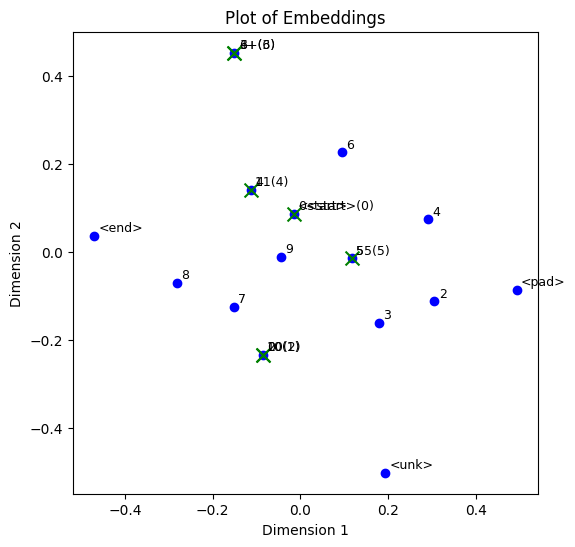

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]

 [[ 0.5659296  -1.3559363   0.30688044  0.3666072   2.4280643
    0.34576255 -1.2468703   4.0490212  -2.1771686   2.3506796
    0.5580593   1.9624902   2.5451977  -1.1528378   1.5894874
    0.32882518]]

 [[-0.46088833  0.8233893  -0.86880255 -1.1207919   1.3748227
    2.3220494  -0.34105128 -1.9635267   3.9689047   2.7193384
    3.457872    0.32516986 -1.9457606   3.590855   -1.9804164
    1.0456802 ]]

 [[-1.210825   -0.08949375  0.7529472  -0.42974535  0.6506746
    3.6217713   3.2136846   1.7112185  -0.7703686   0.46043378
    1.0307511  -0.4175738  -2.5019457  -2.167472    1.775966

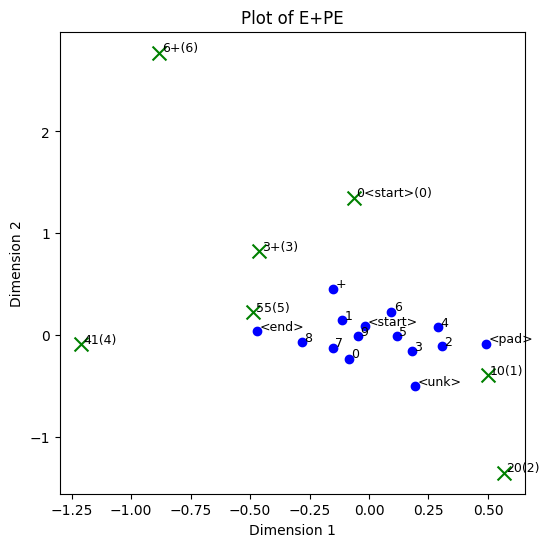

SelfAttention Layer
QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 7, 16])
WV.shape: torch.Size([1, 7, 16])
attn_weight.shape: torch.Size([1, 7, 7])
AV.shape: torch.Size([1, 7, 16])
[[[ 2.898752    1.3413106  -0.96077406 -0.61616176  1.8549097
    2.0887039   1.7566996  -0.39319834  0.06204695 -2.266425
   -0.3832729  -0.8796243   0.26444596 -1.8576146   0.06698968
   -3.3566103 ]]

 [[-0.15404092  0.78526473 -0.7402418   1.082967    2.7352328
   -1.4195635  -1.7351445  -1.8207252   1.1517594   0.13257754
    2.235066    1.0708319   0.5276529   0.9069961  -3.135806
    3.074249  ]]

 [[-0.38616246  0.7339467  -0.8249907   1.1473235   2.8115911
   -1.610875   -1.8657397  -1.7899791   1.1204156   0.25106442
    2.350599    1.0897605   0.4468483   0.9218605  -3.2342055
    3.2906148 ]]

 [[ 2.878769    1.3281498  -0.9670033  -0.5617742   1.8323951
    2.02815     1.7206303  -0.39029965  0.03701141 -2.2400024
   -0.3681454  -0.9162914   0.27029547 -1.8477895   0.10822685
   -3.3

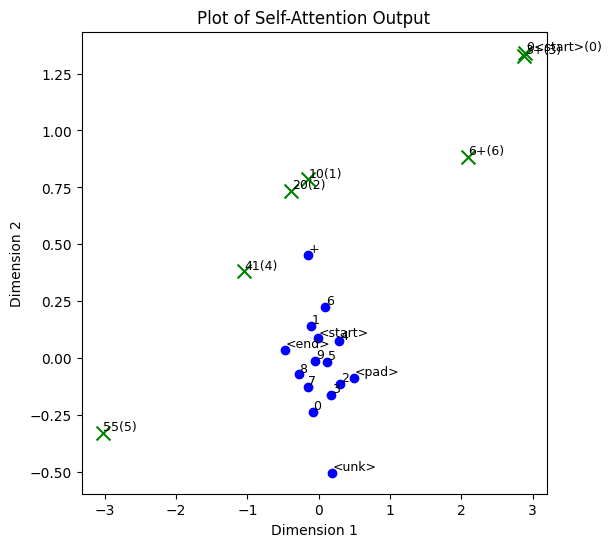

[[[ 1.7039204   1.210748   -0.45964757  0.9446592  -1.1004351
    1.0260196   1.7712289   0.530505   -0.12179355 -1.172958
   -0.99981725  0.34756738 -0.3846619  -1.9797889   0.5856877
   -1.1107734 ]]

 [[-0.5429485  -0.29519305 -0.6877513   0.40068918  2.0839882
   -1.0996994  -2.1533113   0.37937972 -0.8459956   0.731386
    0.78501135  0.5237054   0.9418653  -0.70218    -1.1615366
    1.2034445 ]]

 [[-0.5984084  -0.77902955 -0.5607986   0.37587646  2.103121
   -1.1243632  -2.078292    0.3891489  -0.79325265  0.7799902
    0.8192942   0.51664233  0.8923465  -0.6380424  -1.1280854
    1.2799928 ]]

 [[ 1.2286515   0.82729703 -0.9037104  -0.9763841   1.2110585
    1.6687198   0.34225488 -1.1066393   1.3155117  -0.0500118
    0.985888   -0.5656041  -0.83702075  0.47645444 -1.0485358
   -1.3532597 ]]

 [[-2.1885707   0.1383887  -0.5949455   0.45972794  1.9307798
    0.77672344  0.9906029   0.3738431  -0.57440406  0.09854297
    1.406205   -0.45174837 -1.5378807  -1.8092371  -0.03834695

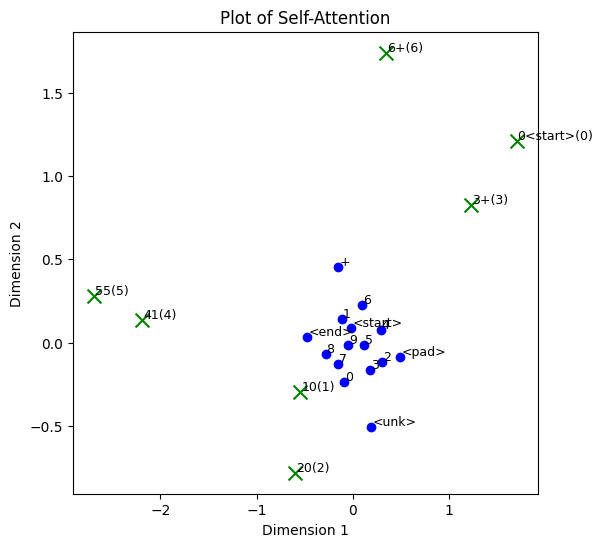

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 16])
After Attention: tensor([[[-9.6817e-01, -3.6935e-01, -1.1985e+00, -5.4980e-02,  3.0253e+00, -3.3102e+00, -8.3362e-01,
           3.5830e+00, -4.6841e+00, -2.3573e-01, -1.6295e+00,  1.3646e+00,  4.5659e+00, -2.7592e-01,
          -2.3403e-01,  1.2756e+00]],

        [[-6.7319e-01,  1.4523e+00, -1.0119e+00, -1.0620e+00,  7.8821e-01,  1.0300e+00, -1.3320e+00,
          -4.5188e+00,  3.7112e+00, -1.1058e-01,  4.4409e+00, -7.5801e-01, -2.5344e+00,  2.3736e+00,
          -1.2771e+00, -6.2473e-01]],

        [[-6.9957e-01,  1.2930e+00, -9.4573e-01, -1.0710e+00,  7.9944e-01,  1.0226e+00, -1.2781e+00,
          -4.5271e+00,  3.7604e+00, -8.8590e-02,  4.4853e+00, -7.6162e-01, -2.5704e+00,  2.4235e+00,
          -1.2683e+00, -5.8359e-01]],

        [[-9.1238e-01,  2.9638e-01, -4.6938e-02, -1.3250e+00,  7.1490e-01,  3.2551e+

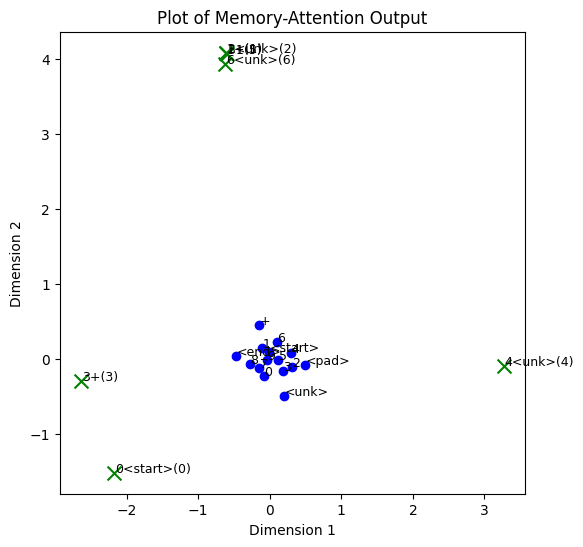

[[[-9.68168139e-01 -3.69345099e-01 -1.19854438e+00 -5.49799502e-02
    3.02527881e+00 -3.31020594e+00 -8.33620310e-01  3.58302069e+00
   -4.68412495e+00 -2.35726237e-01 -1.62952232e+00  1.36460006e+00
    4.56585646e+00 -2.75915712e-01 -2.34030709e-01  1.27563179e+00]]

 [[-6.73186660e-01  1.45226455e+00 -1.01191139e+00 -1.06195307e+00
    7.88207054e-01  1.03000367e+00 -1.33196759e+00 -4.51875830e+00
    3.71120119e+00 -1.10578455e-01  4.44086266e+00 -7.58009017e-01
   -2.53435349e+00  2.37360978e+00 -1.27708590e+00 -6.24733508e-01]]

 [[-6.99572563e-01  1.29298830e+00 -9.45732176e-01 -1.07097960e+00
    7.99437642e-01  1.02264881e+00 -1.27806377e+00 -4.52714920e+00
    3.76041007e+00 -8.85902941e-02  4.48525429e+00 -7.61624634e-01
   -2.57040143e+00  2.42346001e+00 -1.26830077e+00 -5.83592713e-01]]

 [[-9.12382901e-01  2.96384752e-01 -4.69380654e-02 -1.32499361e+00
    7.14901626e-01  3.25513530e+00  7.65373135e+00 -1.17846978e+00
   -9.62764382e-01  6.88540161e-01  2.90559506e+00 -1

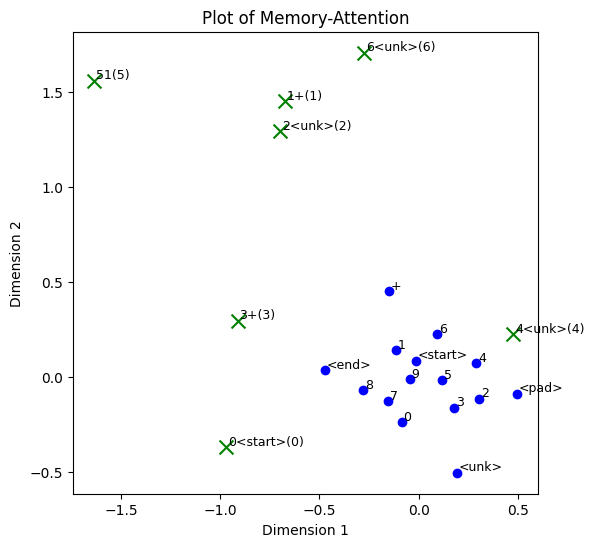

output.shape: torch.Size([1, 15])
output: tensor([[-8.7102,  0.9016, -6.0969, -6.2251, -1.9001,  1.5904,  0.8268,  1.9792,  0.9040, -2.9585,
          1.0047,  0.0215, -5.8222,  2.3251, 16.2744]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 14

------------------

iter: 7
ys: tensor([[12],
        [ 0],
        [ 0],
        [14],
        [ 1],
        [ 5],
        [14],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.0622,  1.3477,  0.8706,  2.9122, -2.6757,  0.6450,  2.0359,  2.6638,  0.5624,  1.0902,
          -1.0209,  3.0590, -0.2724, -0.4394,  2.0376,  2.3900]],

        [[ 0.4981, -0.3995,  0.0267,  0.5104,  2.3292,  0.3607, -1.2785,  4.0505, -2.1872,  2.3508,
           0.5549,  1.9625,  2.5442, -1.1528,  1.5892,  0.3288]],

        [[ 0.5659, -1.3559,  0.3069,  0.3666,  2.4281,  0.3458, -1.2469,  4.0490, -2.1772,  2.3507,
           0.5581,  1.9625,  2.5452, -1.1528,  1.5895,  0.3288]],

        [[-0.4609,  0.8234, -0.8688, -1.1208,  1.3748,  2.3220, -0.3411, -

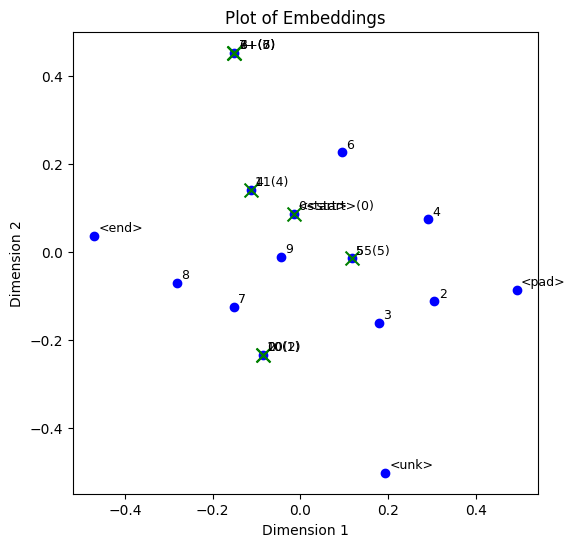

[[[-0.06217712  1.347655    0.87057406  2.9122128  -2.675665
    0.64495176  2.0359273   2.663774    0.56235677  1.0901512
   -1.0208848   3.059027   -0.2723844  -0.43941522  2.0376105
    2.389998  ]]

 [[ 0.49810314 -0.39948714  0.02673694  0.5104441   2.3292286
    0.36070013 -1.2784561   4.050521   -2.1871674   2.3508296
    0.554897    1.9625051   2.5441976  -1.1528363   1.5891713
    0.3288253 ]]

 [[ 0.5659296  -1.3559363   0.30688044  0.3666072   2.4280643
    0.34576255 -1.2468703   4.0490212  -2.1771686   2.3506796
    0.5580593   1.9624902   2.5451977  -1.1528378   1.5894874
    0.32882518]]

 [[-0.46088833  0.8233893  -0.86880255 -1.1207919   1.3748227
    2.3220494  -0.34105128 -1.9635267   3.9689047   2.7193384
    3.457872    0.32516986 -1.9457606   3.590855   -1.9804164
    1.0456802 ]]

 [[-1.210825   -0.08949375  0.7529472  -0.42974535  0.6506746
    3.6217713   3.2136846   1.7112185  -0.7703686   0.46043378
    1.0307511  -0.4175738  -2.5019457  -2.167472    1.775966

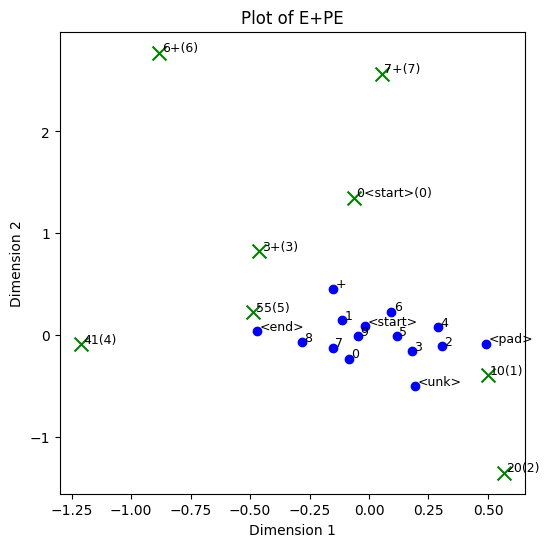

SelfAttention Layer
QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 8, 16])
WV.shape: torch.Size([1, 8, 16])
attn_weight.shape: torch.Size([1, 8, 8])
AV.shape: torch.Size([1, 8, 16])
[[[  2.898752     1.3413106   -0.96077406  -0.61616176   1.8549097
     2.0887039    1.7566996   -0.39319834   0.06204695  -2.266425
    -0.3832729   -0.8796243    0.26444596  -1.8576146    0.06698968
    -3.3566103 ]]

 [[ -0.15420769   0.78509     -0.74026203   1.0841408    2.7346556
    -1.4207222   -1.7358917   -1.8207841    1.1512699    0.13314715
     2.2353327    1.0699564    0.52794284   0.90727717  -3.1348271
     3.0751379 ]]

 [[ -0.38688898   0.7330885   -0.82504904   1.1532347    2.8086271
    -1.6166451   -1.869459    -1.7902924    1.1179528    0.2538895
     2.351891     1.0853157    0.4483582    0.923276    -3.229195
     3.2950065 ]]

 [[  2.8699973    1.3238989   -0.9669514   -0.5369612    1.823393
     2.0002382    1.7003163   -0.39406583   0.03003604  -2.2250078
    -0.3583302

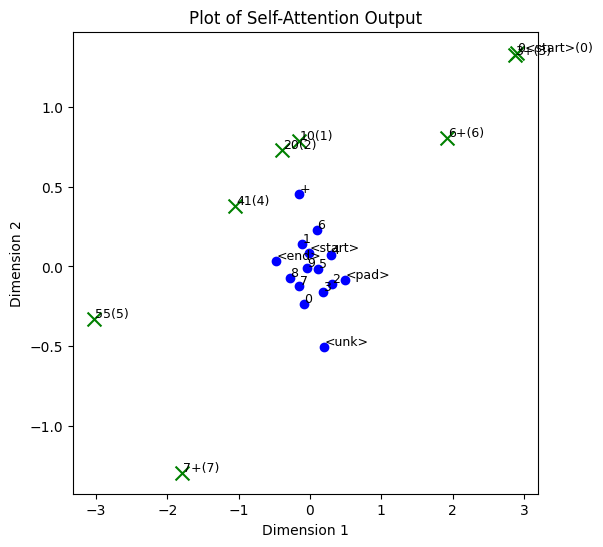

[[[ 1.7039204   1.210748   -0.45964757  0.9446592  -1.1004351
    1.0260196   1.7712289   0.530505   -0.12179355 -1.172958
   -0.99981725  0.34756738 -0.3846619  -1.9797889   0.5856877
   -1.1107734 ]]

 [[-0.54305255 -0.295274   -0.6877227   0.4012642   2.0835555
   -1.1002246  -2.153586    0.37932745 -0.8461538   0.7316176
    0.78507257  0.5233574   0.9419336  -0.7020027  -1.1610456
    1.2038188 ]]

 [[-0.5988155  -0.7792738  -0.5606826   0.37864286  2.101001
   -1.1268513  -2.0796125   0.38888556 -0.7940287   0.7810641
    0.819555    0.51495606  0.8927038  -0.6372107  -1.1257033
    1.281723  ]]

 [[ 1.2263249   0.8274347  -0.90727836 -0.9690059   1.2107114
    1.6614898   0.3331803  -1.111965    1.3171235  -0.04388193
    0.9924253  -0.5713171  -0.8383176   0.4828423  -1.0476332
   -1.3452038 ]]

 [[-2.197408    0.1344662  -0.59567416  0.4828794   1.9221232
    0.75572777  0.97542757  0.3712291  -0.58236575  0.10925674
    1.41298    -0.46354204 -1.535697   -1.8055264  -0.024949

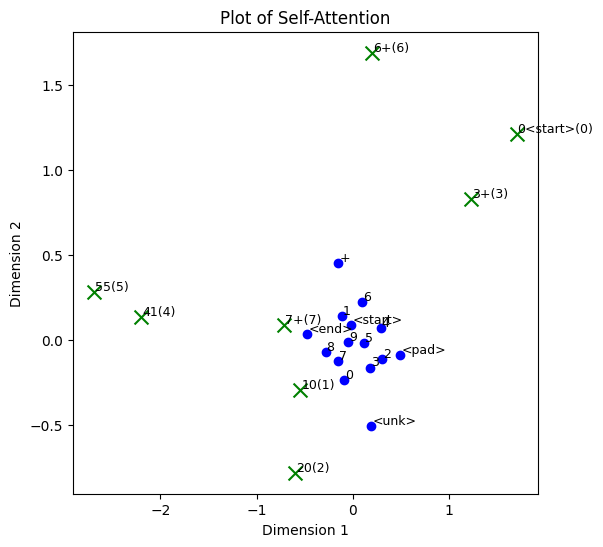

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 15, 16])
WV.shape: torch.Size([1, 15, 16])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 16])
After Attention: tensor([[[-9.6817e-01, -3.6935e-01, -1.1985e+00, -5.4980e-02,  3.0253e+00, -3.3102e+00, -8.3362e-01,
           3.5830e+00, -4.6841e+00, -2.3573e-01, -1.6295e+00,  1.3646e+00,  4.5659e+00, -2.7592e-01,
          -2.3403e-01,  1.2756e+00]],

        [[-6.7325e-01,  1.4523e+00, -1.0119e+00, -1.0618e+00,  7.8802e-01,  1.0297e+00, -1.3322e+00,
          -4.5188e+00,  3.7112e+00, -1.1049e-01,  4.4410e+00, -7.5816e-01, -2.5343e+00,  2.3737e+00,
          -1.2769e+00, -6.2454e-01]],

        [[-6.9982e-01,  1.2930e+00, -9.4574e-01, -1.0700e+00,  7.9851e-01,  1.0212e+00, -1.2791e+00,
          -4.5276e+00,  3.7602e+00, -8.8165e-02,  4.4857e+00, -7.6236e-01, -2.5703e+00,  2.4241e+00,
          -1.2675e+00, -5.8267e-01]],

        [[-9.1490e-01,  2.9966e-01, -4.9960e-02, -1.3239e+00,  7.1373e-01,  3.2499e+

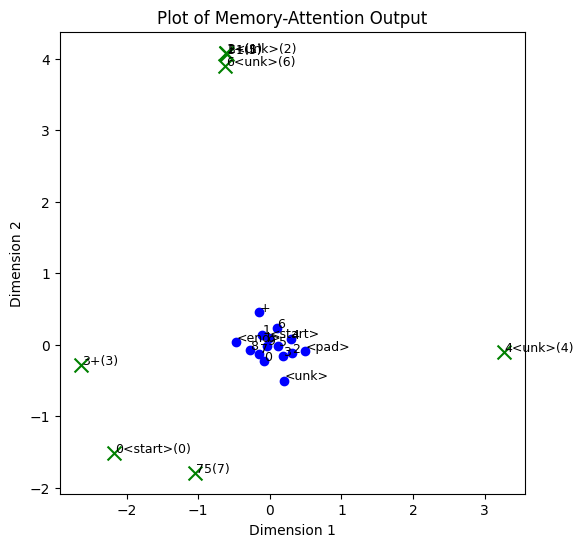

[[[-9.68168139e-01 -3.69345099e-01 -1.19854438e+00 -5.49799502e-02
    3.02527881e+00 -3.31020594e+00 -8.33620310e-01  3.58302069e+00
   -4.68412495e+00 -2.35726237e-01 -1.62952232e+00  1.36460006e+00
    4.56585646e+00 -2.75915712e-01 -2.34030709e-01  1.27563179e+00]]

 [[-6.73247457e-01  1.45225179e+00 -1.01191103e+00 -1.06175578e+00
    7.88017929e-01  1.02970362e+00 -1.33219230e+00 -4.51884985e+00
    3.71115828e+00 -1.10487156e-01  4.44096279e+00 -7.58160591e-01
   -2.53434443e+00  2.37374020e+00 -1.27692151e+00 -6.24535859e-01]]

 [[-6.99824154e-01  1.29296327e+00 -9.45738554e-01 -1.07002759e+00
    7.98505962e-01  1.02121711e+00 -1.27914500e+00 -4.52759981e+00
    3.76019073e+00 -8.81650746e-02  4.48571920e+00 -7.62362957e-01
   -2.57034254e+00  2.42407680e+00 -1.26749837e+00 -5.82673013e-01]]

 [[-9.14895356e-01  2.99659550e-01 -4.99602966e-02 -1.32393074e+00
    7.13730335e-01  3.24988723e+00  7.65319729e+00 -1.20621812e+00
   -9.46758509e-01  6.93680167e-01  2.91251397e+00 -1

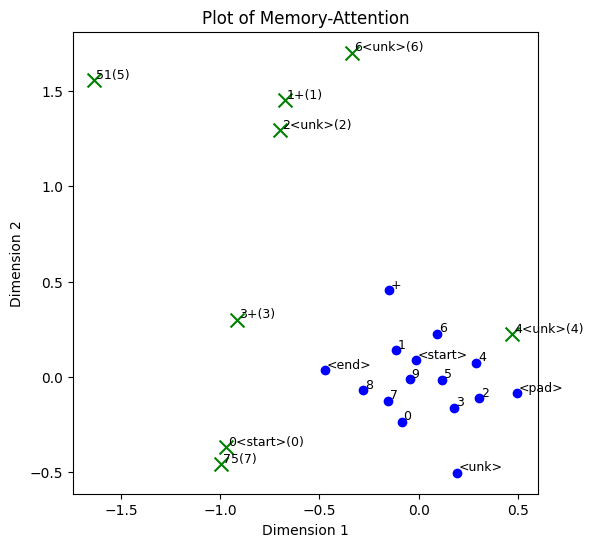

output.shape: torch.Size([1, 15])
output: tensor([[ 7.0357, -9.7148,  7.8914, -2.1572, -2.4304, -4.8850, -4.6245, -2.6442, -8.5645,  1.9365,
         -0.6704, -1.2500, -2.3468, 11.4617, -4.2478]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 13

------------------

Input: + + 1 5 + 8 5
Decoded sequence: 00+15++


In [36]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [37]:
import torch
from torch import nn
import torch.nn.functional as F


In [38]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [39]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

torch.Size([2, 5, 4])
tensor([[[-0.0368,  0.6247,  0.7389,  0.9094],
         [-0.9562,  1.5362, -1.0481,  1.2770],
         [-0.2905,  2.3055,  0.0552,  0.6909],
         [-0.1173, -0.6385,  0.5734,  0.7522],
         [-1.1375,  1.0891, -0.4450, -1.2892]],

        [[-1.6827,  2.2174,  0.5316,  0.6831],
         [ 0.3021, -0.0344,  0.5069, -1.8099],
         [-0.6486, -1.1785, -1.7077, -0.3847],
         [ 0.6255,  1.0303, -1.4109, -0.6960],
         [-0.3817,  0.6987,  1.0540,  0.4631]]])


In [40]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



torch.Size([2, 5, 4])
tensor([[[ 0.2947, -0.0873, -0.0578, -0.1400],
         [ 0.2941, -0.1204, -0.0981, -0.1814],
         [ 0.3036, -0.0757, -0.1025, -0.1974],
         [ 0.2905, -0.0809, -0.0285, -0.1053],
         [ 0.3281,  0.0900, -0.0231, -0.1410]],

        [[ 0.3483, -0.1302,  0.0237, -0.0550],
         [ 0.0831, -0.2120, -0.0560, -0.0546],
         [-0.0192, -0.2675, -0.0800, -0.0414],
         [ 0.1607, -0.2187, -0.0488, -0.0652],
         [ 0.1376, -0.2144, -0.0366, -0.0479]]], grad_fn=<TransposeBackward0>)


In [41]:
from pprint import pprint
pprint(list(model.named_parameters()))

[('in_proj_weight',
  Parameter containing:
tensor([[ 0.3719, -0.1752, -0.1370, -0.1787],
        [ 0.5941,  0.2015, -0.4062,  0.4477],
        [-0.4734,  0.0807,  0.2141,  0.0663],
        [ 0.0268,  0.5818, -0.1561, -0.3914],
        [ 0.3510,  0.0250, -0.4762,  0.6112],
        [-0.5743,  0.2603, -0.5156,  0.0049],
        [ 0.2385,  0.2879, -0.0476,  0.4380],
        [ 0.1037,  0.1797,  0.0340,  0.5166],
        [ 0.4008,  0.5128, -0.5753, -0.4027],
        [-0.0072, -0.1773, -0.3748,  0.1583],
        [-0.3459,  0.4288,  0.3705,  0.3542],
        [ 0.2768, -0.0789,  0.3893,  0.4696]], requires_grad=True)),
 ('in_proj_bias',
  Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('out_proj.weight',
  Parameter containing:
tensor([[-0.3448, -0.2476,  0.4245, -0.2836],
        [-0.2637,  0.1910,  0.0159,  0.3307],
        [-0.4965, -0.1293,  0.0030, -0.3210],
        [-0.4436, -0.0944, -0.1217, -0.3610]], requires_grad=True)),
 ('out_p

In [42]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [43]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [44]:
print(attn_weights_)
print(attn_output_weights)

tensor([[[0.1832, 0.1943, 0.2054, 0.1739, 0.2432],
         [0.1580, 0.2514, 0.2380, 0.1257, 0.2269],
         [0.1781, 0.2654, 0.2569, 0.1337, 0.1659],
         [0.1876, 0.1558, 0.1739, 0.2069, 0.2759],
         [0.2962, 0.1525, 0.2285, 0.2445, 0.0782]],

        [[0.2994, 0.1896, 0.0690, 0.1240, 0.3180],
         [0.1609, 0.1977, 0.1616, 0.2009, 0.2789],
         [0.1598, 0.2149, 0.2310, 0.2120, 0.1823],
         [0.3182, 0.0820, 0.2286, 0.2046, 0.1666],
         [0.2101, 0.2390, 0.1383, 0.1707, 0.2419]]])
tensor([[[0.1832, 0.1943, 0.2054, 0.1739, 0.2432],
         [0.1580, 0.2514, 0.2380, 0.1257, 0.2269],
         [0.1781, 0.2654, 0.2569, 0.1337, 0.1659],
         [0.1876, 0.1558, 0.1739, 0.2069, 0.2759],
         [0.2962, 0.1525, 0.2285, 0.2445, 0.0782]],

        [[0.2994, 0.1896, 0.0690, 0.1240, 0.3180],
         [0.1609, 0.1977, 0.1616, 0.2009, 0.2789],
         [0.1598, 0.2149, 0.2310, 0.2120, 0.1823],
         [0.3182, 0.0820, 0.2286, 0.2046, 0.1666],
         [0.2101, 0.2390,

In [45]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [46]:
print(attn_output_)
print(attn_output)

tensor([[[ 0.2947, -0.0873, -0.0578, -0.1400],
         [ 0.2941, -0.1204, -0.0981, -0.1814],
         [ 0.3036, -0.0757, -0.1025, -0.1974],
         [ 0.2905, -0.0809, -0.0285, -0.1053],
         [ 0.3281,  0.0900, -0.0231, -0.1410]],

        [[ 0.3483, -0.1302,  0.0237, -0.0550],
         [ 0.0831, -0.2120, -0.0560, -0.0546],
         [-0.0192, -0.2675, -0.0800, -0.0414],
         [ 0.1607, -0.2187, -0.0488, -0.0652],
         [ 0.1376, -0.2144, -0.0366, -0.0479]]])
tensor([[[ 0.2947, -0.0873, -0.0578, -0.1400],
         [ 0.2941, -0.1204, -0.0981, -0.1814],
         [ 0.3036, -0.0757, -0.1025, -0.1974],
         [ 0.2905, -0.0809, -0.0285, -0.1053],
         [ 0.3281,  0.0900, -0.0231, -0.1410]],

        [[ 0.3483, -0.1302,  0.0237, -0.0550],
         [ 0.0831, -0.2120, -0.0560, -0.0546],
         [-0.0192, -0.2675, -0.0800, -0.0414],
         [ 0.1607, -0.2187, -0.0488, -0.0652],
         [ 0.1376, -0.2144, -0.0366, -0.0479]]], grad_fn=<TransposeBackward0>)


## nn.Linear

In [47]:
model = nn.Linear(4, 4)
model

Linear(in_features=4, out_features=4, bias=True)

In [48]:
pprint(list(model.named_parameters()))

[('weight',
  Parameter containing:
tensor([[-0.1584, -0.0741, -0.0239, -0.0735],
        [ 0.2781, -0.1000, -0.3946,  0.1128],
        [ 0.4137,  0.3189,  0.0274, -0.4307],
        [-0.4680, -0.3410,  0.4569,  0.3564]], requires_grad=True)),
 ('bias',
  Parameter containing:
tensor([-0.3994,  0.1672, -0.1840,  0.4657], requires_grad=True))]


In [49]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([-2.0992,  0.7827, -0.2637,  1.4945])
torch.Size([4])
tensor([-0.2285, -0.2224, -1.4538,  1.5933], grad_fn=<ViewBackward0>)


In [50]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([-0.2285, -0.2224, -1.4538,  1.5933])
tensor([-0.2285, -0.2224, -1.4538,  1.5933], grad_fn=<ViewBackward0>)


## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [51]:
model = nn.LayerNorm(4)
model

LayerNorm((4,), eps=1e-05, elementwise_affine=True)

In [52]:
pprint(list(model.named_parameters()))

[('weight', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)),
 ('bias', Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True))]


In [53]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([ 0.7041, -1.4015,  0.6284, -1.1805])
torch.Size([4])
tensor([ 1.0350, -1.1089,  0.9579, -0.8840], grad_fn=<NativeLayerNormBackward0>)


In [54]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([-1.2495, -1.2495, -1.2495, -1.2495])
tensor([ 1.0350, -1.1089,  0.9579, -0.8840], grad_fn=<NativeLayerNormBackward0>)


/tmp/ipykernel_201772/3362812588.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  output_ = X.matmul(W.T) + B
